In [1]:
import os
import gc
import cairosvg
import numpy as np
import qcodes as qc
import pandas as pd
import plotly.io as pio
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from tqdm import tqdm
from Analysis_functions import *
from scipy.signal import find_peaks
from IPython.display import clear_output
from plotly.subplots import make_subplots
from qcodes.parameters import Parameter
from qcodes.dataset import (
    Measurement, initialise_or_create_database_at,
    load_or_create_experiment, plot_dataset, plot_by_id)

initialise_or_create_database_at(r"103Data/103_2024-05-11_01.db")
qc.experiments()

[I vs V#103-1K Ohms#1@/Users/albert-mac/Code/Data analysis/103Data/103_2024-05-11_01.db
 --------------------------------------------------------------------------------------
 1-results-1-appl_current,meas_voltage_K2-101,
 I vs V#103-1K Ohms#2@/Users/albert-mac/Code/Data analysis/103Data/103_2024-05-11_01.db
 --------------------------------------------------------------------------------------
 2-results-1-appl_current,meas_voltage_K2-101,
 I vs V#103-1K Ohms#3@/Users/albert-mac/Code/Data analysis/103Data/103_2024-05-11_01.db
 --------------------------------------------------------------------------------------
 3-results-1-appl_current,meas_voltage_K2-101,
 I vs V#103-1K Ohms#4@/Users/albert-mac/Code/Data analysis/103Data/103_2024-05-11_01.db
 --------------------------------------------------------------------------------------
 4-results-1-appl_current,meas_voltage_K2-101,
 I vs V#103-1K Ohms#5@/Users/albert-mac/Code/Data analysis/103Data/103_2024-05-11_01.db
 -------------------

In [2]:
plot_IV_and_dVdI(6524)

Ic = 4.366153846153851 µA
 Ir = -3.1984615384615402 µA
 R_fit = 100.13496689152615 Ω
 IcRn = 437.2046708279254 µV
 R_fit0 = 103.25773098089336 Ω
 R_fit1 = 97.01220280215892 Ω



In [27]:
def find_peaks_and_plot2(df, show_plot=True):
    current_0_index = df['appl_current'].abs().idxmin()

    # Find positive and negative peaks
    positive_peaks, _ = find_peaks(df['dV/dI'][df['appl_current'] > 0])
    negative_peaks, _ = find_peaks(df['dV/dI'][df['appl_current'] < 0])

    # Extract peak information
    positive_peak_current = [df['appl_current'].iloc[current_0_index + i+1] for i in positive_peaks]
    positive_peak_R = [df['dV/dI'].iloc[current_0_index + i+1] for i in positive_peaks]
    negative_peak_current = df['appl_current'].iloc[negative_peaks].values
    negative_peak_R = df['dV/dI'].iloc[negative_peaks].values

    # Find maximum peaks
    positive_peak_index = np.argmax(positive_peak_R)
    negative_peak_index = np.argmax(negative_peak_R)

    if show_plot:
        # Print peak information
        print("Positive peak:")
        print(f"  Current: {positive_peak_current[positive_peak_index]}")
        print(f"  dV/dI: {positive_peak_R[positive_peak_index]:.2f}")
        print("Negative peak:")
        print(f"  Current: {negative_peak_current[negative_peak_index]}")
        print(f"  dV/dI: {negative_peak_R[negative_peak_index]:.2f}")
        # Plot the data and peaks
        plt.plot(df['appl_current'], df['dV/dI'])
        plt.scatter(positive_peak_current, positive_peak_R, color='red', label='Positive Peak')
        plt.scatter(negative_peak_current, negative_peak_R, color='blue', label='Negative Peak')
        plt.legend()
        plt.show()
    else:
        return positive_peak_current[positive_peak_index], negative_peak_current[negative_peak_index]


In [20]:
print(df['appl_current'].sub(Ir).abs().idxmin())

38


In [23]:
df['appl_current'].iloc[39]

-4.4e-07

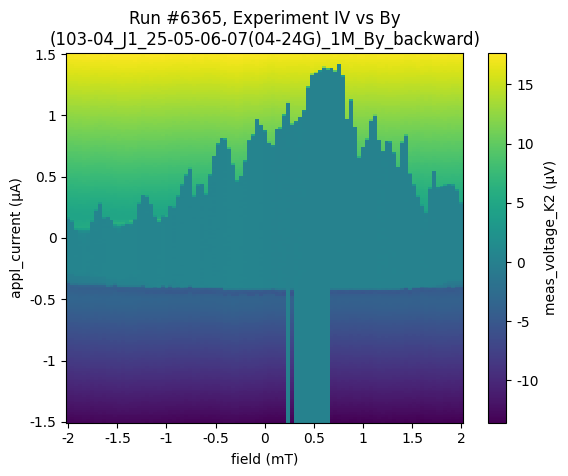

In [34]:
dataset = qc.load_by_id(6365
                        )
axeslist = plot_dataset(dataset)

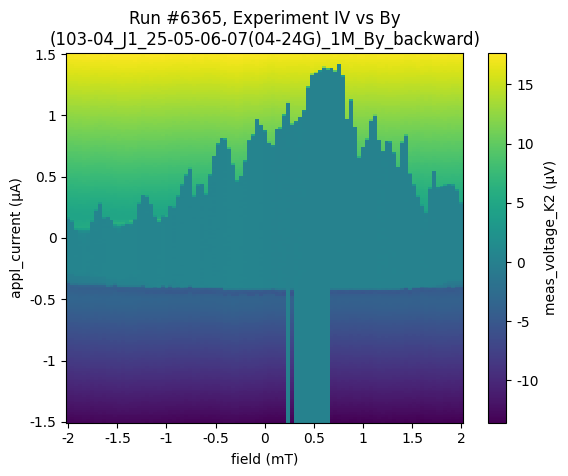

In [35]:
dataset = qc.load_by_id(6365)
axeslist = plot_dataset(dataset)
df = dataset.to_pandas_dataframe().reset_index()
para_list = dataset.parameters.split(",")
run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(
dataset)
df['dV/dI'] = pd.DataFrame(np.diff(df['meas_voltage_K2']) / np.diff(df['appl_current']), columns=['r']).reindex(df.index, method=None)

In [4]:
df

y_field  appl_current  meas_voltage_K2    dV/dI
0       -0.005     -0.000005        -0.000356   68.946
1       -0.005     -0.000005        -0.000353   90.440
2       -0.005     -0.000005        -0.000348   86.286
3       -0.005     -0.000005        -0.000344   68.998
4       -0.005     -0.000005        -0.000340  103.858
...        ...           ...              ...      ...
40396    0.005      0.000005         0.000365   86.518
40397    0.005      0.000005         0.000369   86.022
40398    0.005      0.000005         0.000373   73.768
40399    0.005      0.000005         0.000377  108.520
40400    0.005      0.000005         0.000383      NaN

[40401 rows x 4 columns]

In [43]:
def get_R_fit_df(df_group):
    df_group = df_group.reset_index(drop=True)
    df_group['dV/dI'] = pd.DataFrame(np.diff(df_group['meas_voltage_K2']) / np.diff(df_group['appl_current']), columns=['r']).reindex(df_group.index, method=None)
    peaks, _ = find_peaks(df_group['dV/dI'])
    if len(peaks) < 2:
        return pd.Series({
            'R_fit': np.nan,
            'R_fit0': np.nan,
            'R_fit1': np.nan,
            'top_two_peak_current': [np.nan, np.nan],
            'Ic': np.nan,
            'IcRn': np.nan,
            'current_0_index': np.nan
        })
    # 提取峰值電流和峰值微分電壓值
    peak_current = [df_group['appl_current'][i] for i in peaks]
    peak_R = [df_group['dV/dI'][i] for i in peaks]

    # 根據值對峰進行排序
    sorted_peak_indices = np.argsort(peak_R)[::-1]  # 降序排序
    top_two_peak_indices = sorted_peak_indices[:2]  # 選擇前兩個索引

    # 提取前兩個峰
    top_two_peak_current = [peak_current[i] for i in top_two_peak_indices]
    top_two_peak_R = [peak_R[i] for i in top_two_peak_indices]
    
    # 確保 peak0 小於 peak1
    peak0, peak1 = top_two_peak_current
    if peak1 < peak0:
        peak0, peak1 = peak1, peak0
        top_two_peak_current = [peak0, peak1]
    
    df_0 = df_group[df_group['appl_current'] < peak0]
    df_1 = df_group[df_group['appl_current'] > peak1]

    fit_0 = np.polyfit(df_0['appl_current'], df_0['meas_voltage_K2'], 1)
    fit_1 = np.polyfit(df_1['appl_current'], df_1['meas_voltage_K2'], 1)
    R_fit0 = fit_0[0]
    R_fit1 = fit_1[0]
    R_fit = (R_fit0 + R_fit1) / 2
    
    current_0_index = df_group['appl_current'].abs().idxmin()
    Ic = top_two_peak_current[1] - df_group['appl_current'].iloc[current_0_index]
    IcRn = Ic * R_fit

    return pd.Series({
        'R_fit': R_fit,
        'R_fit0': R_fit0,
        'R_fit1': R_fit1,
        'top_two_peak_current': top_two_peak_current,
        'Ic': Ic,
        'IcRn': IcRn,
        'current_0_index': current_0_index
    })

In [36]:
def get_R_fit_df2(df):
    df = df.reset_index(drop=True)
    df['dV/dI'] = pd.DataFrame(np.diff(df['meas_voltage_K2']) / np.diff(df['appl_current']), columns=['r']).reindex(df.index, method=None)
    Ic, Ir = find_peaks_and_plot(df, show_plot=False)
    df_0 = df[df['appl_current'] < Ir]
    df_1 = df[df['appl_current'] > Ic]
    fit_0 = np.polyfit(df_0['appl_current'], df_0['meas_voltage_K2'] , 1)
    fit_1 = np.polyfit(df_1['appl_current'], df_1['meas_voltage_K2'] , 1)
    R_fit0 = fit_0[0]
    R_fit1 = fit_1[0]
    R_fit = (R_fit0 + R_fit1) / 2
    I0_idx = df['appl_current'].abs().idxmin()
    IcRn = Ic*R_fit
    return pd.Series({
        'R_fit': R_fit,
        'R_fit0': R_fit0,
        'R_fit1': R_fit1,
        'Ic': Ic,
        'Ir': Ir,
        'IcRn': IcRn,
    })
    

In [44]:
# 對 y_field 進行分組並應用計算函數
results = df.groupby('y_field').apply(get_R_fit_df, include_groups=False).reset_index()

# 將結果與原始數據合併
df_merged = df.merge(results, on='y_field', how='left')
df_merged

y_field  appl_current  meas_voltage_K2      dV/dI     R_fit    R_fit0  \
0        0.002     -0.000002        -0.000013   5.991333  9.670518  9.347480   
1        0.002     -0.000001        -0.000013  10.338667  9.670518  9.347480   
2        0.002     -0.000001        -0.000013   9.770667  9.670518  9.347480   
3        0.002     -0.000001        -0.000013   7.576667  9.670518  9.347480   
4        0.002     -0.000001        -0.000013  14.334000  9.670518  9.347480   
...        ...           ...              ...        ...       ...       ...   
20296   -0.002      0.000001         0.000017   8.692000  9.635592  9.325324   
20297   -0.002      0.000001         0.000017   9.808667  9.635592  9.325324   
20298   -0.002      0.000001         0.000017   7.502000  9.635592  9.325324   
20299   -0.002      0.000001         0.000017  14.004667  9.635592  9.325324   
20300   -0.002      0.000002         0.000017        NaN  9.635592  9.325324   

         R_fit1   top_two_peak_current            Ic      IcRn  \
0      9.993556  [-4.05e-07, 2.85e-07]  2.850000e-07  0.000003   
1      9.993556  [-4.05e-07, 2.85e-07]  2.850000e-07  0.000003   
2      9.993556  [-4.05e-07, 2.85e-07]  2.850000e-07  0.000003   
3      9.993556  [-4.05e-07, 2.85e-07]  2.850000e-07  0.000003   
4      9.993556  [-4.05e-07, 2.85e-07]  2.850000e-07  0.000003   
...         ...                    ...           ...       ...   
20296  9.945861   [-3.75e-07, 1.5e-07]  1.500000e-07  0.000001   
20297  9.945861   [-3.75e-07, 1.5e-07]  1.500000e-07  0.000001   
20298  9.945861   [-3.75e-07, 1.5e-07]  1.500000e-07  0.000001   
20299  9.945861   [-3.75e-07, 1.5e-07]  1.500000e-07  0.000001   
20300  9.945861   [-3.75e-07, 1.5e-07]  1.500000e-07  0.000001   

       current_0_index  
0                  100  
1                  100  
2                  100  
3                  100  
4                  100  
...                ...  
20296              100  
20297              100  
20298              100  
20299              100  
20300              100  

[20301 rows x 11 columns]

<Axes: xlabel='y_field', ylabel='R_fit1'>

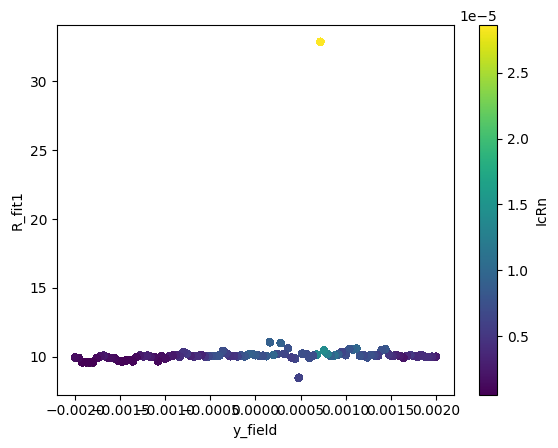

In [45]:
df_merged.plot(x='y_field', y='R_fit1', kind='scatter', c='IcRn', colormap='viridis')

<Axes: xlabel='y_field', ylabel='R_fit'>

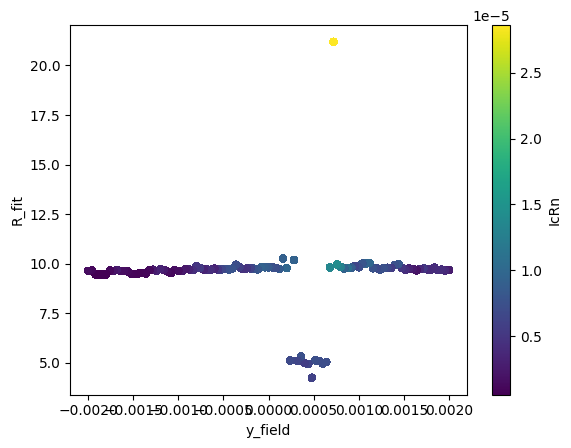

In [46]:
df_merged.plot(x='y_field', y='R_fit', kind='scatter', c='IcRn', colormap='viridis')

<Axes: xlabel='y_field', ylabel='R_fit0'>

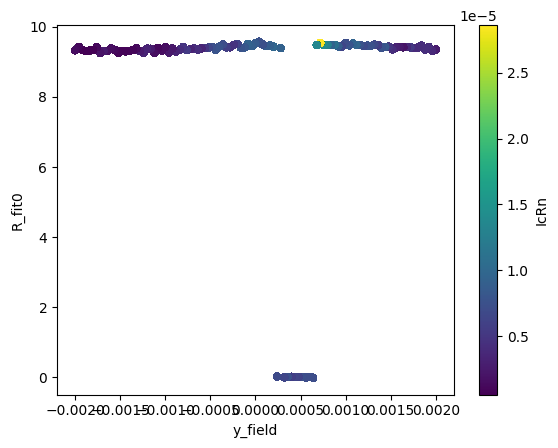

In [47]:
df_merged.plot(x='y_field', y='R_fit0', kind='scatter', c='IcRn', colormap='viridis')

<Axes: xlabel='y_field', ylabel='IcRn'>

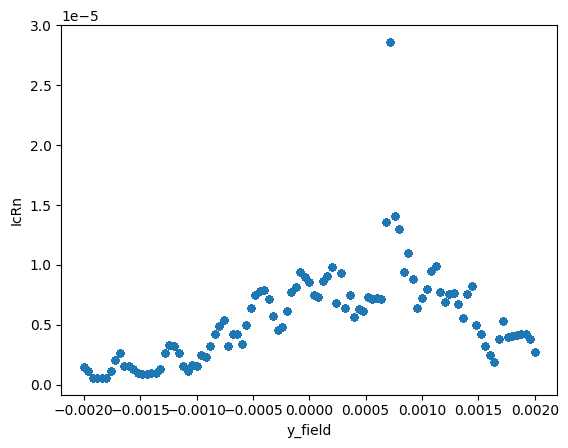

In [48]:
df_merged.plot(x='y_field', y='IcRn', kind='scatter')

<Axes: xlabel='y_field', ylabel='Ic'>

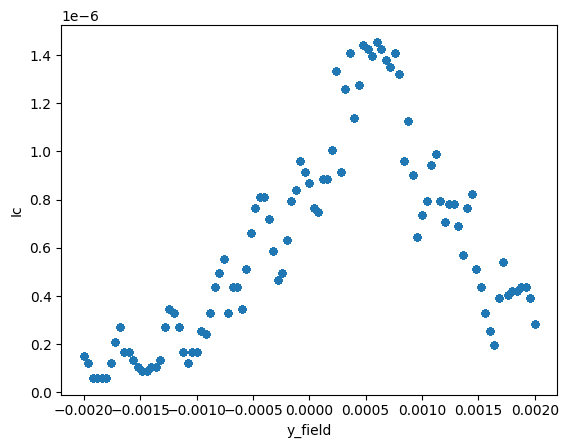

In [49]:
df_merged.plot(x='y_field', y='Ic', kind='scatter')

In [43]:
fig = go.Figure()
trace1 = go.Scatter(x=df_merged['y_field'], y=df_merged['R_fit'], mode='lines', name='R_fit')
trace2 = go.Scatter(x=df_merged['y_field'], y=df_merged['R_fit0'], mode='lines', name='R_fit0')
trace3 = go.Scatter(x=df_merged['y_field'], y=df_merged['R_fit1'], mode='lines', name='R_fit1')

layout = go.Layout(
        # title=f'<b>#{run_id} {exp_name} {sample_name}<br>R_fit={R_fit:.4f} Ω', 
        # title_font=dict(size=25), title_x=0,
        xaxis=dict(title=para_list[0], tickfont=dict(size=16),title_font=dict(size=20)),
        yaxis=dict(title=f"R_fit", tickfont=dict(size=16),title_font=dict(size=20)),
        # yaxis2=dict(title='R_fit0', tickfont=dict(size=16),title_font=dict(size=20), overlaying='y', side='right'),
        width=1000, height=1000, margin=dict(l=10, r=10, t=50, b=10),
        legend=dict(orientation="h",
                    x=0.5, y=1.03,
                    xanchor="center", yanchor="top",))
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

In [12]:
def IV_By_linecut(run_id, target_Bys=[0.0, 1.0]):
    dataset = qc.load_by_id(run_id)
    run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(
        dataset)
    df = dataset.to_pandas_dataframe().reset_index()
    para_list = dataset.parameters.split(",")

    fig = go.Figure()

    for target_B in target_Bys:
        # Find the closest value to the target frequency
        closest_B = df[para_list[0]].iloc[(
            df[para_list[0]]-target_B*1e-3).abs().argsort()[:1]].values[0]

        # Filter the data for the closest frequency
        B_cut = df[df[para_list[0]] == closest_B]

        # Linecut plot
        fig.add_trace(go.Scatter(x=B_cut[para_list[1]], y=B_cut[para_list[2]], mode='lines', name=f'{closest_B*1e3:.4f} mT'))

    fig.update_layout(
        title=f"#{run_id} {exp_name} {sample_name} <br> Linecut",
        xaxis_title=para_list[1],
        yaxis_title=para_list[2],
        height=800, width=800,
        legend=dict(
            orientation="h",
            yanchor="top",
            y=1.05,
            xanchor="center",
            x=0.5
        ))

    fig.show()
IV_By_linecut(6500, target_Bys=[0.0, 0.3, 0.5])

In [55]:
df_merged

y_field  appl_current  meas_voltage_K2    dV/dI      R_fit     R_fit0  \
0       -0.005     -0.000005        -0.000356   68.946  81.573798  80.890764   
1       -0.005     -0.000005        -0.000353   90.440  81.573798  80.890764   
2       -0.005     -0.000005        -0.000348   86.286  81.573798  80.890764   
3       -0.005     -0.000005        -0.000344   68.998  81.573798  80.890764   
4       -0.005     -0.000005        -0.000340  103.858  81.573798  80.890764   
...        ...           ...              ...      ...        ...        ...   
40396    0.005      0.000005         0.000365   86.518  84.365887  83.863855   
40397    0.005      0.000005         0.000369   86.022  84.365887  83.863855   
40398    0.005      0.000005         0.000373   73.768  84.365887  83.863855   
40399    0.005      0.000005         0.000377  108.520  84.365887  83.863855   
40400    0.005      0.000005         0.000383      NaN  84.365887  83.863855   

          R_fit1        Ic        Ir      IcRn  
0      82.256833  0.000001 -0.000001  0.000102  
1      82.256833  0.000001 -0.000001  0.000102  
2      82.256833  0.000001 -0.000001  0.000102  
3      82.256833  0.000001 -0.000001  0.000102  
4      82.256833  0.000001 -0.000001  0.000102  
...          ...       ...       ...       ...  
40396  84.867918  0.000002 -0.000001  0.000148  
40397  84.867918  0.000002 -0.000001  0.000148  
40398  84.867918  0.000002 -0.000001  0.000148  
40399  84.867918  0.000002 -0.000001  0.000148  
40400  84.867918  0.000002 -0.000001  0.000148  

[40401 rows x 10 columns]

In [56]:
closest_B = df_merged[para_list[0]].iloc[(df_merged[para_list[0]]-0*1e-3).abs().argsort()[:1]].values[0]
closest_B

0.0

In [57]:
df_B_cut = df[df_merged[para_list[0]] == closest_B]
df_B_cut 

y_field  appl_current  meas_voltage_K2      dV/dI
20100      0.0     -0.000005        -0.000339   77.39200
20101      0.0     -0.000005        -0.000335   98.09200
20102      0.0     -0.000005        -0.000330   96.45600
20103      0.0     -0.000005        -0.000325   99.92000
20104      0.0     -0.000005        -0.000320   99.33400
...        ...           ...              ...        ...
20296      0.0      0.000005         0.000350   97.44800
20297      0.0      0.000005         0.000355   62.12000
20298      0.0      0.000005         0.000358  131.20400
20299      0.0      0.000005         0.000365   97.96200
20300      0.0      0.000005         0.000370   70.89819

[201 rows x 4 columns]

In [62]:
current_0_index = df['appl_current'].abs().idxmin()

In [63]:
current_0_index 

100

Positive peak:
  Current: 4.35e-06
  dV/dI: 3432.53
Negative peak:
  Current: -3.25e-06
  dV/dI: 1520.69


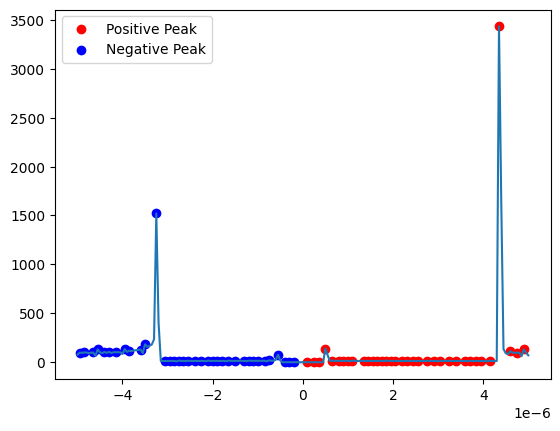

In [64]:
def find_peaks_and_plot2(df, show_plot=True, current_0_index = 100):
    # current_0_index = df['appl_current'].abs().idxmin()

    # Find positive and negative peaks
    positive_peaks, _ = find_peaks(df['dV/dI'][df['appl_current'] > 0])
    negative_peaks, _ = find_peaks(df['dV/dI'][df['appl_current'] < 0])

    # Extract peak information
    positive_peak_current = [df['appl_current'].iloc[current_0_index + i+1] for i in positive_peaks]
    positive_peak_R = [df['dV/dI'].iloc[current_0_index + i+1] for i in positive_peaks]
    negative_peak_current = df['appl_current'].iloc[negative_peaks].values
    negative_peak_R = df['dV/dI'].iloc[negative_peaks].values

    # Find maximum peaks
    positive_peak_index = np.argmax(positive_peak_R)
    negative_peak_index = np.argmax(negative_peak_R)

    if show_plot:
        # Print peak information
        print("Positive peak:")
        print(f"  Current: {positive_peak_current[positive_peak_index]}")
        print(f"  dV/dI: {positive_peak_R[positive_peak_index]:.2f}")
        print("Negative peak:")
        print(f"  Current: {negative_peak_current[negative_peak_index]}")
        print(f"  dV/dI: {negative_peak_R[negative_peak_index]:.2f}")
        # Plot the data and peaks
        plt.plot(df['appl_current'], df['dV/dI'])
        plt.scatter(positive_peak_current, positive_peak_R, color='red', label='Positive Peak')
        plt.scatter(negative_peak_current, negative_peak_R, color='blue', label='Negative Peak')
        plt.legend()
        plt.show()
find_peaks_and_plot2(df_B_cut, show_plot=True)

In [59]:
find_peaks_and_plot(df_B_cut, show_plot=True)

IndexError: single positional indexer is out-of-bounds

In [51]:
def IV_By_single_linecut(run_id, target_B=0.0):
    dataset = qc.load_by_id(run_id)
    run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(
        dataset)
    df = dataset.to_pandas_dataframe().reset_index()
    df['dV/dI'] = pd.DataFrame(np.diff(df['meas_voltage_K2']) / np.diff(df['appl_current']), columns=['r']).reindex(df.index, method=None)
    para_list = dataset.parameters.split(",")

    fig = go.Figure()
    closest_B = df[para_list[0]].iloc[(df[para_list[0]]-target_B*1e-3).abs().argsort()[:1]].values[0]
    df_B_cut = df[df[para_list[0]] == closest_B]
    Ic, Ir = find_peaks_and_plot(df_B_cut, show_plot=False)
    df_0 = df[df_B_cut['appl_current'] < Ir]
    df_1 = df[df_B_cut['appl_current'] > Ic]
    fit_0 = np.polyfit(df_0['appl_current'], df_0['meas_voltage_K2'] , 1)
    fit_1 = np.polyfit(df_1['appl_current'], df_1['meas_voltage_K2'] , 1)
    R_fit0 = fit_0[0]
    R_fit1 = fit_1[0]
    R_fit = (R_fit0 + R_fit1) / 2
    current_0_index = df_B_cut['appl_current'].abs().idxmin()
    IcRn = Ic*R_fit

    # Trace1 IV
    trace1 = go.Scatter(x=df['appl_current'], y=df['meas_voltage_K2'], mode='lines', name='IV')
    # Trace2 dV/dI
    trace2 = go.Scatter(x=df['appl_current'], y=df['dV/dI'], mode='lines', name='dV/dI', yaxis='y2')
    trace3 = go.Scatter(x=[Ir, Ir], y=[df['dV/dI'].min(), df['dV/dI'].max()], mode='lines', line=dict(dash='dash'), name='Peak0',yaxis='y2')
    trace4 = go.Scatter(x=[Ic, Ic], y=[df['dV/dI'].min(), df['dV/dI'].max()], mode='lines', line=dict(dash='dash'), name='Peak1',yaxis='y2')
    trace5 = go.Scatter(x=[df['appl_current'].iloc[current_0_index], df['appl_current'].iloc[current_0_index]], y=[df['dV/dI'].min(), df['dV/dI'].max()], mode='lines', line=dict(dash='dash'), name='I_0',yaxis='y2')
    trace6 = go.Scatter(x=[df['appl_current'].iloc[current_0_index], Ic], y=[0, 0], mode='lines', line=dict(dash='dash'), name='Ic')
    # Trace7 I_r
    trace7 = go.Scatter(x=[df['appl_current'].iloc[current_0_index], Ir], y=[0, 0], mode='lines', line=dict(dash='dash'), name='Ir')
    # Trace8 R_fit 
    trace8 = go.Scatter(x=[df['appl_current'].min(), df['appl_current'].max()], y=[R_fit*df['appl_current'].min(), R_fit*df['appl_current'].max()], mode='lines', line=dict(dash='dash'), name='R_fit') 
    
    # Create layout
    layout = go.Layout(
        title=f'<b>#{run_id} {exp_name} {sample_name}<br>R_fit={R_fit:.4f} Ω', 
        title_font=dict(size=25), title_x=0,
        xaxis=dict(title=para_list[0], tickfont=dict(size=16),title_font=dict(size=20)),
        yaxis=dict(title=f"{para_list[1]}", tickfont=dict(size=16),title_font=dict(size=20)),
        yaxis2=dict(title='dV/dI', tickfont=dict(size=16),title_font=dict(size=20), overlaying='y', side='right'),
        width=1000, height=1000, margin=dict(l=10, r=10, t=50, b=10),
        legend=dict(orientation="h",
                    x=0.5, y=1.03,
                    xanchor="center", yanchor="top",)
    )

    fig = go.Figure(data=[trace1, trace2, trace3, trace4, trace5, trace6, trace7, trace8], layout=layout)
    fig.update_layout(
        annotations=[
            go.layout.Annotation(
                x=1,
                y=1,
                xref="paper",
                yref="paper",
                text=f"Ic: {Ic*1e6:.3f}µA, Ir: {Ir*1e6:.3f}µA, IcRn: {IcRn*1e6:.3f}µV",
                showarrow=False,
                font=dict(
                    size=16,
                    color="#ffffff"
                ),
                align="right",
                bgcolor="#ff7f0e",
                opacity=0.8
            )
        ]
    )
    fig.show()
    print(f"Ic = {Ic*1e6} µA\n",
          f"Ir = {Ir*1e6} µA\n", 
          f"R_fit = {R_fit} Ω\n", 
          f"IcRn = {Ic*1e6*R_fit} µV\n",
          f"R_fit0 = {R_fit0} Ω\n", 
          f"R_fit1 = {R_fit1} Ω\n",
          )
IV_By_single_linecut(6500, target_B=0.0)

IndexError: single positional indexer is out-of-bounds

In [54]:
closest_B = df[para_list[0]].iloc[(df[para_list[0]]-0*1e-3).abs().argsort()[:1]].values[0]
df_B_cut = df[df[para_list[0]] == closest_B]
df_B_cut 

y_field  appl_current  meas_voltage_K2      dV/dI
20100      0.0     -0.000005        -0.000339   77.39200
20101      0.0     -0.000005        -0.000335   98.09200
20102      0.0     -0.000005        -0.000330   96.45600
20103      0.0     -0.000005        -0.000325   99.92000
20104      0.0     -0.000005        -0.000320   99.33400
...        ...           ...              ...        ...
20296      0.0      0.000005         0.000350   97.44800
20297      0.0      0.000005         0.000355   62.12000
20298      0.0      0.000005         0.000358  131.20400
20299      0.0      0.000005         0.000365   97.96200
20300      0.0      0.000005         0.000370   70.89819

[201 rows x 4 columns]

In [30]:
para_list = dataset.parameters.split(",")

In [31]:
para_list

['y_field', 'appl_current', 'meas_voltage_K2']

In [9]:
df.to_csv(f"103Data/{6500}.csv")

Positive peak:
  Current: 1.16e-06
  dV/dI: 7030.54
Negative peak:
  Current: -8e-07
  dV/dI: 1309.84


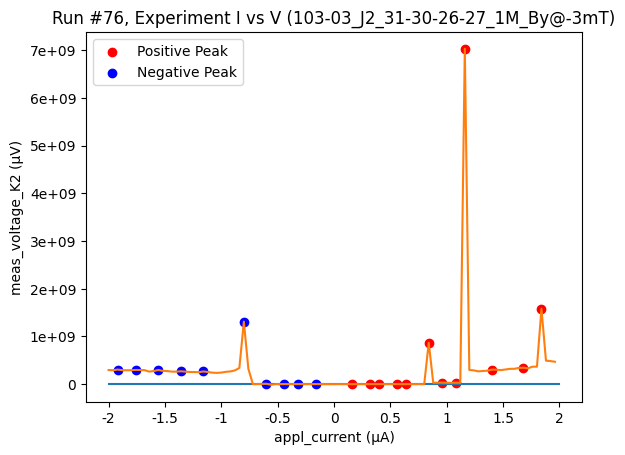

In [28]:
dataset = qc.load_by_id(76)
axeslist = plot_dataset(dataset)
df = dataset.to_pandas_dataframe().reset_index()
para_list = dataset.parameters.split(",")
run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(
dataset)
df['dV/dI'] = pd.DataFrame(np.diff(df['meas_voltage_K2']) / np.diff(df['appl_current']), columns=['r']).reindex(df.index, method=None)
find_peaks_and_plot2(df, show_plot=True)
Ic,Ir = find_peaks_and_plot2(df, show_plot=False)

In [ ]:
def get_R_fit_df(df_group):
    df_group = df_group.reset_index(drop=True)
    df_group['dV/dI'] = pd.DataFrame(np.diff(df_group['meas_voltage_K2']) / np.diff(df_group['appl_current']), columns=['r']).reindex(df_group.index, method=None)
    peaks, _ = find_peaks(df_group['dV/dI'])
    if len(peaks) < 2:
        return pd.Series({
            'R_fit': np.nan,
            'R_fit0': np.nan,
            'R_fit1': np.nan,
            'top_two_peak_current': [np.nan, np.nan],
            'Ic': np.nan,
            'IcRn': np.nan,
            'current_0_index': np.nan
        })
    # 提取峰值電流和峰值微分電壓值
    peak_current = [df_group['appl_current'][i] for i in peaks]
    peak_R = [df_group['dV/dI'][i] for i in peaks]

    # 根據值對峰進行排序
    sorted_peak_indices = np.argsort(peak_R)[::-1]  # 降序排序
    top_two_peak_indices = sorted_peak_indices[:2]  # 選擇前兩個索引

    # 提取前兩個峰
    top_two_peak_current = [peak_current[i] for i in top_two_peak_indices]
    top_two_peak_R = [peak_R[i] for i in top_two_peak_indices]
    
    # 確保 peak0 小於 peak1
    peak0, peak1 = top_two_peak_current
    if peak1 < peak0:
        peak0, peak1 = peak1, peak0
        top_two_peak_current = [peak0, peak1]
    
    df_0 = df_group[df_group['appl_current'] < peak0]
    df_1 = df_group[df_group['appl_current'] > peak1]

    fit_0 = np.polyfit(df_0['appl_current'], df_0['meas_voltage_K2'], 1)
    fit_1 = np.polyfit(df_1['appl_current'], df_1['meas_voltage_K2'], 1)
    R_fit0 = fit_0[0]
    R_fit1 = fit_1[0]
    R_fit = (R_fit0 + R_fit1) / 2
    
    current_0_index = df_group['appl_current'].abs().idxmin()
    Ic = top_two_peak_current[1] - df_group['appl_current'].iloc[current_0_index]
    IcRn = Ic * R_fit

    return pd.Series({
        'R_fit': R_fit,
        'R_fit0': R_fit0,
        'R_fit1': R_fit1,
        'top_two_peak_current': top_two_peak_current,
        'Ic': Ic,
        'IcRn': IcRn,
        'current_0_index': current_0_index
    })


In [ ]:
def IV_df_load_by_id(run_id):
    dataset = qc.load_by_id(run_id)
    axeslist = plot_dataset(dataset)
    df = dataset.to_pandas_dataframe().reset_index()
    para_list = dataset.parameters.split(",")
    run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(
    dataset)
    df['dV/dI'] = pd.DataFrame(np.diff(df['meas_voltage_K2']) / np.diff(df['appl_current']), columns=['r']).reindex(df.index, method=None)
    return df

In [ ]:
df = IV_df_load_by_id(6220)
df

In [ ]:
def IVB_df_load_by_id(run_id):
    dataset = qc.load_by_id(run_id)
    axeslist = plot_dataset(dataset)
    df = dataset.to_pandas_dataframe().reset_index()
    para_list = dataset.parameters.split(",")
    run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(
    dataset)
    df['dV/dI'] = pd.DataFrame(np.diff(df['meas_voltage_K2']) / np.diff(df['appl_current']), columns=['r']).reindex(df.index, method=None)
    R_fit, R_fit0 ,R_fit1, top_two_peak_current, Ic, IcRn, current_0_index = get_R_fit(run_id)
    df['R_fit'] = R_fit
    df['Ic'] = Ic
    df['IcRn'] = IcRn
    if df['dV/dI'].min() <= 0:
        df['dV/dI(Log)'] = df['dV/dI'] - df['dV/dI'].min() + 1
    df['dV/dI(Log)'] = np.log10(df['dV/dI(Log)'])
    return df
df = IVB_df_load_by_id(6220)
df

In [ ]:
dataset = qc.load_by_id(285)
axeslist = plot_dataset(dataset)
df = dataset.to_pandas_dataframe().reset_index()
para_list = dataset.parameters.split(",")
run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(
dataset)
df['dV/dI'] = pd.DataFrame(np.diff(df['meas_voltage_K2']) / np.diff(df['appl_current']), columns=['r']).reindex(df.index, method=None)

In [ ]:
def get_R_fit_df(df_group):
    df_group = df_group.reset_index(drop=True)
    df_group['dV/dI'] = pd.DataFrame(np.diff(df_group['meas_voltage_K2']) / np.diff(df_group['appl_current']), columns=['r']).reindex(df_group.index, method=None)
    peaks, _ = find_peaks(df_group['dV/dI'])
    if len(peaks) < 2:
        return pd.Series({
            'R_fit': np.nan,
            'R_fit0': np.nan,
            'R_fit1': np.nan,
            'top_two_peak_current': [np.nan, np.nan],
            'Ic': np.nan,
            'IcRn': np.nan,
            'current_0_index': np.nan
        })
    # 提取峰值電流和峰值微分電壓值
    peak_current = [df_group['appl_current'][i] for i in peaks]
    peak_R = [df_group['dV/dI'][i] for i in peaks]

    # 根據值對峰進行排序
    sorted_peak_indices = np.argsort(peak_R)[::-1]  # 降序排序
    top_two_peak_indices = sorted_peak_indices[:2]  # 選擇前兩個索引

    # 提取前兩個峰
    top_two_peak_current = [peak_current[i] for i in top_two_peak_indices]
    top_two_peak_R = [peak_R[i] for i in top_two_peak_indices]
    
    # 確保 peak0 小於 peak1
    peak0, peak1 = top_two_peak_current
    if peak1 < peak0:
        peak0, peak1 = peak1, peak0
        top_two_peak_current = [peak0, peak1]
    
    df_0 = df_group[df_group['appl_current'] < peak0]
    df_1 = df_group[df_group['appl_current'] > peak1]

    fit_0 = np.polyfit(df_0['appl_current'], df_0['meas_voltage_K2'], 1)
    fit_1 = np.polyfit(df_1['appl_current'], df_1['meas_voltage_K2'], 1)
    R_fit0 = fit_0[0]
    R_fit1 = fit_1[0]
    R_fit = (R_fit0 + R_fit1) / 2
    
    current_0_index = df_group['appl_current'].abs().idxmin()
    Ic = top_two_peak_current[1] - df_group['appl_current'].iloc[current_0_index]
    IcRn = Ic * R_fit

    return pd.Series({
        'R_fit': R_fit,
        'R_fit0': R_fit0,
        'R_fit1': R_fit1,
        'top_two_peak_current': top_two_peak_current,
        'Ic': Ic,
        'IcRn': IcRn,
        'current_0_index': current_0_index
    })

# 對 y_field 進行分組並應用計算函數
results = df.groupby('y_field').apply(get_R_fit_df, include_groups=False).reset_index()

# 將結果與原始數據合併
df_merged = df.merge(results, on='y_field', how='left')
df_merged

In [ ]:
unique_results = df_merged.drop_duplicates(subset=['y_field'])
unique_results

In [ ]:
unique_results.to_csv('103Data/6220_unique_results.csv', index=False)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

In [ ]:
H_data = unique_results['y_field']
Ic_data = unique_results['Ic']

In [ ]:
# Define the Fraunhofer pattern function
def fraunhofer_pattern(H, Ic0, w, lambda_eff, d_barrier):
    mu_0 = 4 * np.pi * 1e-7
    Phi_0 = 2.07e-15
    Phi = mu_0 * H * w * (2 * lambda_eff + d_barrier)
    Ic = Ic0 * np.abs(np.sinc(Phi / Phi_0))
    return Ic

# Initial guesses for the fitting parameters
initial_guess = [1e-3, 1e-6, 50e-9, 10e-9]

# Fit the data
popt, pcov = curve_fit(fraunhofer_pattern, H_data, Ic_data, p0=initial_guess)

# Extract the fitted parameters
Ic0_fit, w_fit, lambda_eff_fit, d_barrier_fit = popt

# Print the fitted parameters
print(f"Fitted Ic0: {Ic0_fit:.2e} A")
print(f"Fitted w: {w_fit:.2e} m")
print(f"Fitted lambda_eff: {lambda_eff_fit:.2e} m")
print(f"Fitted d_barrier: {d_barrier_fit:.2e} m")


In [ ]:
# Plot the original and fitted data
plt.figure(figsize=(10, 6))
plt.scatter(H_data, Ic_data, label='Experimental Data', color='red')
H_fit = np.linspace(H_data.min(), H_data.max(), 1000)
Ic_fit = fraunhofer_pattern(H_fit, *popt)
plt.plot(H_fit, Ic_fit, label='Fitted Fraunhofer Pattern', color='blue')
plt.xlabel('Magnetic Field H (T)')
plt.ylabel('Critical Current Ic (A)')
plt.title('Experimental Data and Fitted Fraunhofer Pattern')
plt.legend()
plt.show()


In [ ]:
# Define multiple sets of initial guesses
initial_guesses = [
    [1e-3, 1e-6, 50e-9, 10e-9],
    [1e-4, 2e-6, 60e-9, 20e-9],
    [1e-5, 3e-6, 70e-9, 30e-9],
    [5e-4, 1.5e-6, 55e-9, 15e-9],
    [2e-4, 2.5e-6, 65e-9, 25e-9]
]

best_fit_params = None
best_fit_cov = None
best_fit_residual = float('inf')

# Iterate over the different initial guesses
for initial_guess in initial_guesses:
    try:
        popt, pcov = curve_fit(fraunhofer_pattern, H_data, Ic_data, p0=initial_guess)
        residuals = np.sum((fraunhofer_pattern(H_data, *popt) - Ic_data) ** 2)
        if residuals < best_fit_residual:
            best_fit_residual = residuals
            best_fit_params = popt
            best_fit_cov = pcov
    except RuntimeError:
        continue

# Display the best fit parameters if fitting was successful
if best_fit_params is not None:
    Ic0_fit, w_fit, lambda_eff_fit, d_barrier_fit = best_fit_params
    print(f"Best Fitted Ic0: {Ic0_fit:.2e} A")
    print(f"Best Fitted w: {w_fit:.2e} m")
    print(f"Best Fitted lambda_eff: {lambda_eff_fit:.2e} m")
    print(f"Best Fitted d_barrier: {d_barrier_fit:.2e} m")

    # Plot the original and best-fitted data
    plt.figure(figsize=(10, 6))
    plt.scatter(H_data, Ic_data, label='Experimental Data', color='red')
    H_fit = np.linspace(H_data.min(), H_data.max(), 1000)
    Ic_fit = fraunhofer_pattern(H_fit, *best_fit_params)
    plt.plot(H_fit, Ic_fit, label='Best Fitted Fraunhofer Pattern', color='blue')
    plt.xlabel('Magnetic Field H (T)')
    plt.ylabel('Critical Current Ic (A)')
    plt.title('Experimental Data and Best Fitted Fraunhofer Pattern')
    plt.legend()
    plt.show()
else:
    print("Fitting was not successful with any of the initial guesses.")


In [ ]:
from scipy.optimize import curve_fit
from sklearn.model_selection import ParameterSampler
import numpy as np

# Define the parameter grid
param_grid = {
    'Ic0': np.logspace(-5, -3, 100),
    'w': np.logspace(-7, -5, 100),
    'lambda_eff': np.logspace(-9, -7, 100),
    'd_barrier': np.logspace(-9, -7, 100)
}

# Define the number of iterations
n_iter = 100

# Create the parameter sampler
param_sampler = ParameterSampler(param_grid, n_iter)

best_fit_params = None
best_fit_cov = None
best_fit_residual = float('inf')

# Iterate over the parameter samples
for params in param_sampler:
    initial_guess = [params['Ic0'], params['w'], params['lambda_eff'], params['d_barrier']]
    try:
        popt, pcov = curve_fit(fraunhofer_pattern, H_data, Ic_data, p0=initial_guess)
        residuals = np.sum((fraunhofer_pattern(H_data, *popt) - Ic_data) ** 2)
        if residuals < best_fit_residual:
            best_fit_residual = residuals
            best_fit_params = popt
            best_fit_cov = pcov
    except RuntimeError:
        continue

In [ ]:
from scipy.optimize import leastsq

# Define the error function
def residuals(params, H_data, Ic_data):
    return Ic_data - fraunhofer_pattern(H_data, *params)

# Define the initial guess
initial_guess = [1e-4, 1e-6, 1e-8, 1e-8]

# Perform the least squares fit
best_fit_params, flag = leastsq(residuals, initial_guess, args=(H_data, Ic_data))

# Print the best fit parameters
print(best_fit_params)

In [ ]:
import pymc3 as pm
import theano.tensor as tt

# Define the model
with pm.Model() as model:
    # Define the priors
    Ic0 = pm.Uniform('Ic0', lower=1e-5, upper=1e-3)
    w = pm.Uniform('w', lower=1e-7, upper=1e-5)
    lambda_eff = pm.Uniform('lambda_eff', lower=1e-9, upper=1e-7)
    d_barrier = pm.Uniform('d_barrier', lower=1e-9, upper=1e-7)

    # Define the likelihood
    mu = fraunhofer_pattern(H_data, Ic0, w, lambda_eff, d_barrier)
    likelihood = pm.Normal('y', mu=mu, sd=1, observed=Ic_data)

# Perform the sampling
with model:
    trace = pm.sample(2000, tune=1000)

# Print the summary
pm.summary(trace).round(2)

In [ ]:
ax = df_merged.plot(x='y_field', y='R_fit', kind='scatter', color='Red', label='R_fit')
df_merged.plot(x='y_field', y='Ic', kind='scatter', color='Blue', label='Ic', ax=ax)

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

# 繪製 Ic 對 y_field 的散點圖，並設置 y 軸標籤和顏色
ax1.scatter(df_merged['y_field'], df_merged['Ic'], color='blue')
ax1.set_ylabel('Ic', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# 創建一個共享 x 軸但有不同 y 軸的圖
ax2 = ax1.twinx()

# 繪製 R_fit 對 y_field 的散點圖，並設置 y 軸標籤和顏色
ax2.scatter(df_merged['y_field'], df_merged['IcRn'], color='red')
ax2.set_ylabel('R_fit', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.show()

In [ ]:
df_merged.plot(x='y_field', y1='R_fit',y2='Ic', kind='scatter')

In [ ]:
df_merged.plot(x='y_field', y='meas_voltage_K2', kind='scatter', c='dV/dI', colormap='RdBu', colorbar=True)

In [ ]:
# 對 y_field 進行分組並應用計算函數
results = df.groupby('y_field').apply(get_R_fit_df, include_groups=False).reset_index()

# 將結果與原始數據合併
df_merged = df.merge(results, on='y_field', how='left')
df_merged

In [ ]:
df_merged

In [ ]:
df.to_csv('104Data/IVB_285.csv')

In [ ]:
# 示例一维数组
flattened_array = np.array(df['y_field'])

# 推断形状
inferred_shape = infer_shape_from_repeated_values(flattened_array)

# 恢复二维数组
restored_array = flattened_array.reshape(inferred_shape)

In [ ]:
inferred_shape

In [ ]:
restored_array[2]

In [ ]:
df

In [ ]:
dataset = qc.load_by_id(285)
df = dataset.to_pandas_dataframe().reset_index()
para_list = dataset.parameters.split(",")
run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(
    dataset)
df['dV/dI'] = pd.DataFrame(np.diff(df['meas_voltage_K2']) / np.diff(df['appl_current']), columns=['r']).reindex(df.index, method=None)
peaks, _ = find_peaks(df['dV/dI'])
# Extract peak current and peak differential voltage values
peak_current = [df['appl_current'][i] for i in peaks]
peak_R = [df['dV/dI'][i] for i in peaks]

# Sort the peaks based on their values
sorted_peak_indices = np.argsort(peak_R)[::-1]  # Sort in descending order
top_two_peak_indices = sorted_peak_indices[:2]  # Select the top two indices

# Extract the top two peaks
top_two_peak_current = [peak_current[i] for i in top_two_peak_indices]
top_two_peak_R = [peak_R[i] for i in top_two_peak_indices]
# Ensure peak0 is less than paek1
peak0, peak1 = top_two_peak_current
if peak1 < peak0:
    peak0, peak1 = peak1, peak0
    top_two_peak_current = peak0, peak1
df_0 = df[df['appl_current'] < peak0]
df_1 = df[df['appl_current'] > peak1]

fit_0 = np.polyfit(df_0['appl_current'], df_0['meas_voltage_K2'] , 1)
fit_1 = np.polyfit(df_1['appl_current'], df_1['meas_voltage_K2'] , 1)
R_fit0 = fit_0[0]
R_fit1 = fit_1[0]
R_fit = (R_fit0 + R_fit1) / 2
current_0_index = df['appl_current'].abs().idxmin()
Ic = top_two_peak_current[1]-df['appl_current'].iloc[current_0_index]
IcRn = Ic*R_fit

# df['resistance'] = pd.DataFrame(np.diff(df[para_list[2]]) / np.diff(df[para_list[1]]), columns=['r']).reindex(df.index, method=None)
# df['resistance(Log)'] = np.log10(df['resistance'].replace(0, 1e-20).clip(lower=1))
df

In [ ]:
dataset = qc.load_by_id(285)
axeslist = plot_dataset(dataset)
axeslist[0][0]

In [ ]:
plot_IV_and_dVdI(311)

In [ ]:
def get_R_fit(run_id):
    # ... existing code ...

    # Select the top two indices that satisfy the condition
    top_two_peak_indices = []
    for index in sorted_peak_indices:
        if len(top_two_peak_indices) == 0 and index < current_0_index:
            top_two_peak_indices.append(index)
        elif len(top_two_peak_indices) == 1 and index > current_0_index:
            top_two_peak_indices.append(index)
        if len(top_two_peak_indices) == 2:
            break

    # Check if we have at least two peaks
    if len(top_two_peak_indices) < 2:
        raise ValueError("Not enough peaks found")

    # Extract the top two peaks
    top_two_peak_current = [peak_current[i] for i in top_two_peak_indices]
    top_two_peak_R = [peak_R[i] for i in top_two_peak_indices]

    # Ensure peak0 is less than peak1
    peak0, peak1 = top_two_peak_current
    if peak1 < peak0:
        peak0, peak1 = peak1, peak0
        top_two_peak_current = peak0, peak1

    # ... existing code ...

In [ ]:
def get_R_fit(run_id):
    dataset = qc.load_by_id(run_id)
    df = dataset.to_pandas_dataframe().reset_index()
    para_list = dataset.parameters.split(",")
    run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(
        dataset)
    df['dV/dI'] = pd.DataFrame(np.diff(df['meas_voltage_K2']) / np.diff(df['appl_current']), columns=['r']).reindex(df.index, method=None)
    peaks, _ = find_peaks(df['dV/dI'])
    current_0_index = df['appl_current'].abs().idxmin()
    # Extract peak current and peak differential voltage values
    peak_current = [df['appl_current'][i] for i in peaks]
    peak_R = [df['dV/dI'][i] for i in peaks]

    # Sort the peaks based on their values
    sorted_peak_indices = np.argsort(peak_R)[::-1]  # Sort in descending order
    top_two_peak_indices = sorted_peak_indices[:2]  # Select the top two indices

    # Extract the top two peaks
    top_two_peak_current = [peak_current[i] for i in top_two_peak_indices]
    top_two_peak_R = [peak_R[i] for i in top_two_peak_indices]
    
    # Select the top two indices that satisfy the condition
    top_two_peak_indices = []
    for index in sorted_peak_indices:
        if len(top_two_peak_indices) == 0 and index < current_0_index:
            top_two_peak_indices.append(index)
        elif len(top_two_peak_indices) == 1 and index > current_0_index:
            top_two_peak_indices.append(index)
        if len(top_two_peak_indices) == 2:
            break

    # Check if we have at least two peaks
    if len(top_two_peak_indices) < 2:
        raise ValueError("Not enough peaks found")

    # Extract the top two peaks
    top_two_peak_current = [peak_current[i] for i in top_two_peak_indices]
    top_two_peak_R = [peak_R[i] for i in top_two_peak_indices]
        
        
    df_0 = df[df['appl_current'] < peak0]
    df_1 = df[df['appl_current'] > peak1]

    fit_0 = np.polyfit(df_0['appl_current'], df_0['meas_voltage_K2'] , 1)
    fit_1 = np.polyfit(df_1['appl_current'], df_1['meas_voltage_K2'] , 1)
    R_fit0 = fit_0[0]
    R_fit1 = fit_1[0]
    R_fit = (R_fit0 + R_fit1) / 2
    
    Ic = top_two_peak_current[1]-df['appl_current'].iloc[current_0_index]
    IcRn = Ic*R_fit
    return R_fit, R_fit0 ,R_fit1, top_two_peak_current, Ic, IcRn, current_0_index

def plot_IV_and_dVdI(run_id=1):
    dataset = qc.load_by_id(run_id)
    run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(dataset)
    df = dataset.to_pandas_dataframe().reset_index()
    df['dV/dI'] = pd.DataFrame(np.diff(df['meas_voltage_K2']) / np.diff(df['appl_current']), columns=['r']).reindex(df.index, method=None)
    para_list = dataset.parameters.split(",")
    R_fit, R_fit0 ,R_fit1, top_two_peak_current, Ic, IcRn, current_0_index = get_R_fit(run_id)
    # Create traces
    # Trace1 IV
    trace1 = go.Scatter(x=df['appl_current'], y=df['meas_voltage_K2'], mode='lines', name='IV')
    # Trace2 dV/dI
    trace2 = go.Scatter(x=df['appl_current'], y=df['dV/dI'], mode='lines', name='dV/dI', yaxis='y2')
    trace3 = go.Scatter(x=[top_two_peak_current[0], top_two_peak_current[0]], y=[df['dV/dI'].min(), df['dV/dI'].max()], mode='lines', line=dict(dash='dash'), name='Peak0',yaxis='y2')
    trace4 = go.Scatter(x=[top_two_peak_current[1], top_two_peak_current[1]], y=[df['dV/dI'].min(), df['dV/dI'].max()], mode='lines', line=dict(dash='dash'), name='Peak1',yaxis='y2')
    trace5 = go.Scatter(x=[df['appl_current'].iloc[current_0_index], df['appl_current'].iloc[current_0_index]], y=[df['dV/dI'].min(), df['dV/dI'].max()], mode='lines', line=dict(dash='dash'), name='I_0',yaxis='y2')
    trace6 = go.Scatter(x=[df['appl_current'].iloc[current_0_index], top_two_peak_current[1]], y=[0, 0], mode='lines', line=dict(dash='dash'), name='Ic')
    # Trace7 R_fit 
    trace7 = go.Scatter(x=[df['appl_current'].min(), df['appl_current'].max()], y=[R_fit*df['appl_current'].min(), R_fit*df['appl_current'].max()], mode='lines', line=dict(dash='dash'), name='R_fit') 
    
    # Create layout
    layout = go.Layout(
        title=f'<b>#{run_id} {exp_name} {sample_name}<br>R_fit={R_fit:.4f} Ω', 
        title_font=dict(size=25), title_x=0,
        xaxis=dict(title=para_list[0], tickfont=dict(size=16),title_font=dict(size=20)),
        yaxis=dict(title=f"{para_list[1]}", tickfont=dict(size=16),title_font=dict(size=20)),
        yaxis2=dict(title='dV/dI', tickfont=dict(size=16),title_font=dict(size=20), overlaying='y', side='right'),
        width=1000, height=1000, margin=dict(l=10, r=10, t=50, b=10),
        legend=dict(orientation="h",
                    x=0.5, y=1.03,
                    xanchor="center", yanchor="top",)
    )

    fig = go.Figure(data=[trace1, trace2, trace3, trace4, trace5, trace6,trace7], layout=layout)
    fig.update_layout(
        annotations=[
            go.layout.Annotation(
                x=1,
                y=1,
                xref="paper",
                yref="paper",
                text=f"Ic = {Ic*1e6:.3f}µA, IcRn = {IcRn*1e6:.3f} µV",
                showarrow=False,
                font=dict(
                    size=16,
                    color="#ffffff"
                ),
                align="right",
                bgcolor="#ff7f0e",
                opacity=0.8
            )
        ]
    )
    fig.show()
    print(f"Ic = {Ic*1e6} µA\n", 
          f"R_fit = {R_fit} Ω\n", 
          f"IcRn = {Ic*1e6*R_fit} µV\n",
          f"R_fit0 = {R_fit0} Ω\n", 
          f"R_fit1 = {R_fit1} Ω\n",
          )
    return 

In [ ]:
R_fit, R_fit0 ,R_fit1, top_two_peak_current, Ic, IcRn, current_0_index = get_R_fit(311)
R_fit

In [ ]:
def IV(run_id=1):
    dataset = qc.load_by_id(run_id)
    R_fit, R_fit0 ,R_fit1, top_two_peak_current, Ic, IcRn, current_0_index = get_R_fit(run_id)
    run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(
        dataset)
    df = dataset.to_pandas_dataframe().reset_index()
    para_list = dataset.parameters.split(",")
    trace = go.Scatter(x=df['appl_current'], y=df['meas_voltage_K2'], mode='lines', name='IV')

    # Create layout with micro-scale y-axis
    layout = go.Layout(title=f'<b>#{run_id} {exp_name} {sample_name}<br>R_fit={R_fit:.4f} Ω', 
                       title_font=dict(size=25),
                       title_x=0,
                       xaxis=dict(title=para_list[0], tickfont=dict(size=16),title_font=dict(size=20)),
                       yaxis=dict(title=f"{para_list[1]}", tickfont=dict(size=16),title_font=dict(size=20)), 
                       width=1000, height=1000,
                       margin=dict(l=10, r=10, t=50, b=10))
    fig = go.Figure(data=[trace], layout=layout)
    fig.show()
IV(311)

In [ ]:
def dVdI(run_id=1):
    dataset = qc.load_by_id(run_id)
    R = get_R_from_IV(run_id)
    run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(
        dataset)
    df = dataset.to_pandas_dataframe().reset_index()
    df['dV/dI'] = pd.DataFrame(np.diff(df['meas_voltage_K2']) / np.diff(df['appl_current']), columns=['r']).reindex(df.index, method=None)
    para_list = dataset.parameters.split(",")
    trace = go.Scatter(x=df['appl_current'], y=df['dV/dI'], mode='lines', name='dV/dI')

    # Create layout with micro-scale y-axis
    layout = go.Layout(title=f'<b>#{run_id} {exp_name} {sample_name}<br>R_fit={R:.4f} Ω', 
                       title_font=dict(size=25),
                       title_x=0,
                       xaxis=dict(title=para_list[1], tickfont=dict(size=16),title_font=dict(size=20)),
                       yaxis=dict(title=f"dV/dI", tickfont=dict(size=16),title_font=dict(size=20)), 
                       width=1000, height=1000,
                       margin=dict(l=10, r=10, t=50, b=10),
                       )
    fig = go.Figure(data=[trace], layout=layout)
    fig.show()
dVdI(311)

In [ ]:
def get_R_from_IV(dataid):
    dataset = qc.load_by_id(dataid)

    voltage = dataset.get_parameter_data(
    )['meas_voltage_K2']['meas_voltage_K2']
    current = dataset.get_parameter_data()['meas_voltage_K2']['appl_current']
    fit_values = np.polyfit(current, voltage, 1)

    return fit_values[0]

In [ ]:
dataset = qc.load_by_id(75)
df = dataset.to_pandas_dataframe().reset_index()
para_list = dataset.parameters.split(",")
run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(
    dataset)
df['dV/dI'] = pd.DataFrame(np.diff(df['meas_voltage_K2']) / np.diff(df['appl_current']), columns=['r']).reindex(df.index, method=None)
Max1, Max2 = df['dV/dI'].nlargest(2).index
# Ensure Max1 is grater than Max2
if Max1 < Max2:
    Max1, Max2 = Max2, Max1
# Filter out the rows between Max1 and Max2
# filtered_df = df.drop(df.index[Max1:Max2+1])
filtered_df = df[df.index <= peak_index2]

In [ ]:
dataset = qc.load_by_id(75)
df = dataset.to_pandas_dataframe().reset_index()
para_list = dataset.parameters.split(",")
run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(
    dataset)
df['dV/dI'] = pd.DataFrame(np.diff(df['meas_voltage_K2']) / np.diff(df['appl_current']), columns=['r']).reindex(df.index, method=None)

In [ ]:
from scipy.signal import find_peaks
peaks, _ = find_peaks(df['dV/dI'])
# Extract peak current and peak differential voltage values
peak_current = [df['appl_current'][i] for i in peaks]
peak_R = [df['dV/dI'][i] for i in peaks]

# Sort the peaks based on their values
sorted_peak_indices = np.argsort(peak_R)[::-1]  # Sort in descending order
top_two_peak_indices = sorted_peak_indices[:2]  # Select the top two indices

# Extract the top two peaks
top_two_peak_current = [peak_current[i] for i in top_two_peak_indices]
top_two_peak_R = [peak_R[i] for i in top_two_peak_indices]


In [ ]:
dataset = qc.load_by_id(run_id)
R = get_R_from_IV(run_id)
run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(dataset)
df = dataset.to_pandas_dataframe().reset_index()
df['dV/dI'] = pd.DataFrame(np.diff(df['meas_voltage_K2']) / np.diff(df['appl_current']), columns=['r']).reindex(df.index, method=None)
para_list = dataset.parameters.split(",")
peaks, _ = find_peaks(df['dV/dI'])
# Extract peak current and peak differential voltage values
peak_current = [df['appl_current'][i] for i in peaks]
peak_R = [df['dV/dI'][i] for i in peaks]

# Sort the peaks based on their values
sorted_peak_indices = np.argsort(peak_R)[::-1]  # Sort in descending order
top_two_peak_indices = sorted_peak_indices[:2]  # Select the top two indices

# Extract the top two peaks
top_two_peak_current = [peak_current[i] for i in top_two_peak_indices]
top_two_peak_R = [peak_R[i] for i in top_two_peak_indices]
df_0 = df[df['appl_current'] > top_two_peak_current[0]]
df_1 = df[df['appl_current'] < top_two_peak_current[1]]

fit_0 = np.polyfit(df_0['appl_current'], df_0['meas_voltage_K2'] , 1)
fit_1 = np.polyfit(df_1['appl_current'], df_1['meas_voltage_K2'] , 1)
R_fit0 = fit_0[0]
R_fit1 = fit_1[0]
R_fit = (R_fit0 + R_fit1) / 2


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
dataset = qc.load_by_id(run_id)
df = dataset.to_pandas_dataframe().reset_index()
para_list = dataset.parameters.split(",")
run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(
    dataset)
df['dV/dI'] = pd.DataFrame(np.diff(df['meas_voltage_K2']) / np.diff(df['appl_current']), columns=['r']).reindex(df.index, method=None)
peaks, _ = find_peaks(df['dV/dI'])
# Extract peak current and peak differential voltage values
peak_current = [df['appl_current'][i] for i in peaks]
peak_R = [df['dV/dI'][i] for i in peaks]

# Sort the peaks based on their values
sorted_peak_indices = np.argsort(peak_R)[::-1]  # Sort in descending order
top_two_peak_indices = sorted_peak_indices[:2]  # Select the top two indices

# Extract the top two peaks
top_two_peak_current = [peak_current[i] for i in top_two_peak_indices]
top_two_peak_R = [peak_R[i] for i in top_two_peak_indices]
# Ensure peak0 is less than paek1
peak0, peak1 = top_two_peak_current
if peak1 < peak0:
    peak0, peak1 = peak1, peak0
    top_two_peak_current = peak0, peak1
df_0 = df[df['appl_current'] < peak0]
df_1 = df[df['appl_current'] > peak1]

fit_0 = np.polyfit(df_0['appl_current'], df_0['meas_voltage_K2'] , 1)
fit_1 = np.polyfit(df_1['appl_current'], df_1['meas_voltage_K2'] , 1)
R_fit0 = fit_0[0]
R_fit1 = fit_1[0]
R_fit = (R_fit0 + R_fit1) / 2
current_0_index = df['appl_current'].abs().idxmin()
Ic = top_two_peak_current[1]-df['appl_current'].iloc[current_0_index]
IcRn = Ic*R_fit
# Example data
x = df_1['appl_current']
y = df_1['meas_voltage_K2']

# Fit a 2nd degree polynomial (quadratic) to the data
degree = 1  
coefficients = np.polyfit(x, y, degree)

# Create a polynomial function from the coefficients
polynomial = np.poly1d(coefficients)

# Generate y-values using the polynomial function
y_fit = polynomial(x)

# Plot the data and the fit
plt.scatter(x, y, label='Data Points')
plt.plot(x, y_fit, label='Fitted Polynomial', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
coefficients

In [ ]:


def plot_IV_and_dVdI(run_id=1):
    def R_fit(run_id):
        import numpy as np
        dataset = qc.load_by_id(run_id)
        df = dataset.to_pandas_dataframe().reset_index()
        para_list = dataset.parameters.split(",")
        run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(
            dataset)
        df['dV/dI'] = pd.DataFrame(np.diff(df['meas_voltage_K2']) / np.diff(df['appl_current']), columns=['r']).reindex(df.index, method=None)
        current_0_index = df['appl_current'].abs().idxmin()
        peaks, _ = find_peaks(df['dV/dI'])
        # Extract peak current and peak differential voltage values
        peak_current = [df['appl_current'][i] for i in peaks]
        peak_R = [df['dV/dI'][i] for i in peaks]

        # Sort the peaks based on their values
        sorted_peak_indices = np.argsort(peak_R)[::-1]  # Sort in descending order
        top_two_peak_indices = sorted_peak_indices[:2]  # Select the top two indices

        # Extract the top two peaks
        top_two_peak_current = [peak_current[i] for i in top_two_peak_indices]
        top_two_peak_R = [peak_R[i] for i in top_two_peak_indices]
        # Ensure peak0 is less than paek1
        peak0, peak1 = top_two_peak_current
        if peak1 < peak0:
            peak0, peak1 = peak1, peak0
            top_two_peak_current = peak0, peak1
        df_0 = df[df['appl_current'] < peak0]
        df_1 = df[df['appl_current'] > peak1]

        fit_0 = np.polyfit(df_0['appl_current'], df_0['meas_voltage_K2'] , 1)
        fit_1 = np.polyfit(df_1['appl_current'], df_1['meas_voltage_K2'] , 1)
        R_fit0 = fit_0[0]
        R_fit1 = fit_1[0]
        R_fit = (R_fit0 + R_fit1) / 2
        Ic = top_two_peak_current[1]-df['appl_current'].iloc[current_0_index]
        Ir = df['appl_current'].iloc[current_0_index]-top_two_peak_current[0]
        IcRn = Ic*R_fit
        return R_fit, R_fit0 ,R_fit1, top_two_peak_current, Ic, Ir, IcRn, current_0_index
    
    dataset = qc.load_by_id(run_id)
    run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(dataset)
    df = dataset.to_pandas_dataframe().reset_index()
    df['dV/dI'] = pd.DataFrame(np.diff(df['meas_voltage_K2']) / np.diff(df['appl_current']), columns=['r']).reindex(df.index, method=None)
    para_list = dataset.parameters.split(",")
    R_fit, R_fit0 ,R_fit1, top_two_peak_current, Ic, Ir, IcRn, current_0_index = R_fit(run_id)
    # Create traces
    # Trace1 IV
    trace1 = go.Scatter(x=df['appl_current'], y=df['meas_voltage_K2'], mode='lines', name='IV')
    # Trace2 dV/dI
    trace2 = go.Scatter(x=df['appl_current'], y=df['dV/dI'], mode='lines', name='dV/dI', yaxis='y2')
    # Trace3 Peak0
    trace3 = go.Scatter(x=[top_two_peak_current[0], top_two_peak_current[0]], y=[df['dV/dI'].min(), df['dV/dI'].max()], mode='lines', line=dict(dash='dash'), name='Peak0',yaxis='y2')
    # Trace4 Peak1
    trace4 = go.Scatter(x=[top_two_peak_current[1], top_two_peak_current[1]], y=[df['dV/dI'].min(), df['dV/dI'].max()], mode='lines', line=dict(dash='dash'), name='Peak1',yaxis='y2')
    # Trace5 I_0
    trace5 = go.Scatter(x=[df['appl_current'].iloc[current_0_index], df['appl_current'].iloc[current_0_index]], y=[df['dV/dI'].min(), df['dV/dI'].max()], mode='lines', line=dict(dash='dash'), name='I_0',yaxis='y2')
    # Trace6 Ic
    trace6 = go.Scatter(x=[df['appl_current'].iloc[current_0_index], top_two_peak_current[1]], y=[0, 0], mode='lines', line=dict(dash='dash'), name='Ic')
    # Trace7 I_r
    trace7 = go.Scatter(x=[df['appl_current'].iloc[current_0_index], top_two_peak_current[0]], y=[0, 0], mode='lines', line=dict(dash='dash'), name='Ir')
    # Trace8 R_fit 
    trace8 = go.Scatter(x=[df['appl_current'].min(), df['appl_current'].max()], y=[R_fit*df['appl_current'].min(), R_fit*df['appl_current'].max()], mode='lines', line=dict(dash='dash'), name='R_fit') 
    
    # Create layout
    layout = go.Layout(
        title=f'<b>#{run_id} {exp_name} {sample_name}<br>R_fit={R_fit:.4f} Ω', 
        title_font=dict(size=25), title_x=0,
        xaxis=dict(title=para_list[0], tickfont=dict(size=16),title_font=dict(size=20)),
        yaxis=dict(title=f"{para_list[1]}", tickfont=dict(size=16),title_font=dict(size=20)),
        yaxis2=dict(title='dV/dI', tickfont=dict(size=16),title_font=dict(size=20), overlaying='y', side='right'),
        width=1000, height=1000, margin=dict(l=10, r=10, t=50, b=10),
        legend=dict(orientation="h",
                    x=0.5, y=1.03,
                    xanchor="center", yanchor="top",)
    )

    fig = go.Figure(data=[trace1, trace2, trace3, trace4, trace5, trace6,trace7, trace8], layout=layout)
    fig.update_layout(
        annotations=[
            go.layout.Annotation(
                x=1,
                y=1,
                xref="paper",
                yref="paper",
                text=f"Ic = {Ic*1e6:.3f}µA, Ir = {Ir*1e6:.3f}µA ,IcRn = {IcRn*1e6:.3f} µV",
                showarrow=False,
                font=dict(
                    size=16,
                    color="#ffffff"
                ),
                align="right",
                bgcolor="#ff7f0e",
                opacity=0.8
            )
        ]
    )
    fig.show()
    print(f"Ic = {Ic*1e6} µA\n", 
          f"Ir = {Ir*1e6} µA\n",
          f"R_fit = {R_fit} Ω\n", 
          f"IcRn = {Ic*1e6*R_fit} µV\n",
          f"R_fit0 = {R_fit0} Ω\n", 
          f"R_fit1 = {R_fit1} Ω\n",
          )
    return 
plot_IV_and_dVdI(6524)

In [ ]:

def find_peaks_and_plot(df):
    current_0_index = df['appl_current'].abs().idxmin()
    # Find peaks in the positive current range
    positivepeaks,  = find_peaks(df['dV/dI'][df['appl_current'] > 0])

    # Extract peak current and peak differential voltage values for positive peaks
    positive_peak_current = [df['appl_current'][current_0_index+i] for i in positive_peaks]
    positive_peak_R = [df['dV/dI'][current_0_index+i] for i in positive_peaks]

    # Sort the peaks based on their values (descending order)
    sorted_positive_peak_indices = np.argsort(positive_peak_R)[::-1]

    # Select the first peak (assuming there's at least one)
    positive_peak_index = sorted_positive_peak_indices[0]

    # Extract the selected peak's current and differential voltage values
    positive_peak_current_value = positive_peak_current[positive_peak_index]
    positive_peak_R_value = positive_peak_R[positive_peak_index]

    print(f"Positive peak:")
    print(f"  Current: {positive_peak_current_value:.2f}")
    print(f"  dV/dI: {positive_peak_R_value:.2f}")

    # Check if peak values are within expected range
    if abs(positive_peak_current_value) > 1e-5:
        print("Warning: Unexpected positive peak current value")

    # Find peaks in the negative current range
    negativepeaks,  = find_peaks(df['dV/dI'][df['appl_current'] < 0])

    # Extract peak current and peak differential voltage values for negative peaks
    negative_peak_current = [df['appl_current'][i] for i in negative_peaks]
    negative_peak_R = [df['dV/dI'][i] for i in negative_peaks]

    # Sort the peaks based on their values (descending order)
    sorted_negative_peak_indices = np.argsort(negative_peak_R)[::-1]

    # Select the first peak (assuming there's at least one)
    negative_peak_index = sorted_negative_peak_indices[0]

    # Extract the selected peak's current and differential voltage values
    negative_peak_current_value = negative_peak_current[negative_peak_index]
    negative_peak_R_value = negative_peak_R[negative_peak_index]

    print(f"Negative peak:")
    print(f"  Current: {negative_peak_current_value:.2f}")
    print(f"  dV/dI: {negative_peak_R_value:.2f}")

    # Check if peak values are within expected range
    if abs(negative_peak_R_value) > 1e5:
        print("Warning: Unexpected negative peak dV/dI value")

    # Plot the data and peaks
    plt.plot(df['appl_current'], df['dV/dI'])
    plt.scatter(positive_peak_current, positive_peak_R, color='red', label='Positive Peak')
    plt.scatter(negative_peak_current, negative_peak_R, color='blue', label='Negative Peak')
    plt.legend()
    plt.show()

In [ ]:
def find_peaks_and_plot(df, show_plot=True):
    current_0_index = df['appl_current'].abs().idxmin()

    # Find positive and negative peaks
    positive_peaks, _ = find_peaks(df['dV/dI'][df['appl_current'] > 0])
    negative_peaks, _ = find_peaks(df['dV/dI'][df['appl_current'] < 0])

    # Extract peak information
    positive_peak_current = [df['appl_current'].iloc[current_0_index + i] for i in positive_peaks]
    positive_peak_R = [df['dV/dI'].iloc[current_0_index + i] for i in positive_peaks]
    negative_peak_current = df['appl_current'].iloc[negative_peaks].values
    negative_peak_R = df['dV/dI'].iloc[negative_peaks].values

    # Find maximum peaks
    positive_peak_index = np.argmax(positive_peak_R)
    negative_peak_index = np.argmax(negative_peak_R)

    if show_plot:
        # Print peak information
        print("Positive peak:")
        print(f"  Current: {positive_peak_current[positive_peak_index]}")
        print(f"  dV/dI: {positive_peak_R[positive_peak_index]:.2f}")
        print("Negative peak:")
        print(f"  Current: {negative_peak_current[negative_peak_index]}")
        print(f"  dV/dI: {negative_peak_R[negative_peak_index]:.2f}")
        # Plot the data and peaks
        plt.plot(df['appl_current'], df['dV/dI'])
        plt.scatter(positive_peak_current, positive_peak_R, color='red', label='Positive Peak')
        plt.scatter(negative_peak_current, negative_peak_R, color='blue', label='Negative Peak')
        plt.legend()
        plt.show()
    else:
        return positive_peak_current[positive_peak_index], negative_peak_current[negative_peak_index]
find_peaks_and_plot(df, show_plot=True)
Ic, Ir = find_peaks_and_plot(df, show_plot=False)

In [ ]:
Ic, Ir 

In [ ]:
filtered_df = df.loc[2245]
filtered_df

In [ ]:
def plot_IV_and_dVdI(run_id=1):
    def R_fit(run_id):
        import numpy as np
        dataset = qc.load_by_id(run_id)
        df = dataset.to_pandas_dataframe().reset_index()
        para_list = dataset.parameters.split(",")
        run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(
            dataset)
        df['dV/dI'] = pd.DataFrame(np.diff(df['meas_voltage_K2']) / np.diff(df['appl_current']), columns=['r']).reindex(df.index, method=None)
        current_0_index = df['appl_current'].abs().idxmin()
        
        df[df['dV/dI'] > df['dV/dI'].index[current_0_index]]
        peaks1, _ = find_peaks(df[df['dV/dI'] > df['dV/dI'].index[current_0_index]])
        peaks0, _ = find_peaks(df[df['dV/dI'] < df['dV/dI'].index[current_0_index]])
        # Extract peak current and peak differential voltage values
        peak1_current = [df['appl_current'][i] for i in peaks1]
        peak1_R = [df['dV/dI'][i] for i in peaks1]

        # Sort the peaks based on their values
        sorted_peak_indices = np.argsort(peak_R)[::-1]  # Sort in descending order
        top_two_peak_indices = sorted_peak_indices[:2]  # Select the top two indices

        # Extract the top two peaks
        top_two_peak_current = [peak_current[i] for i in top_two_peak_indices]
        top_two_peak_R = [peak_R[i] for i in top_two_peak_indices]
        # Ensure peak0 is less than paek1
        peak0, peak1 = top_two_peak_current
        if peak1 < peak0:
            peak0, peak1 = peak1, peak0
            top_two_peak_current = peak0, peak1
        df_0 = df[df['appl_current'] < peak0]
        df_1 = df[df['appl_current'] > peak1]

        fit_0 = np.polyfit(df_0['appl_current'], df_0['meas_voltage_K2'] , 1)
        fit_1 = np.polyfit(df_1['appl_current'], df_1['meas_voltage_K2'] , 1)
        R_fit0 = fit_0[0]
        R_fit1 = fit_1[0]
        R_fit = (R_fit0 + R_fit1) / 2
        Ic = top_two_peak_current[1]-df['appl_current'].iloc[current_0_index]
        Ir = df['appl_current'].iloc[current_0_index]-top_two_peak_current[0]
        IcRn = Ic*R_fit
        return R_fit, R_fit0 ,R_fit1, top_two_peak_current, Ic, Ir, IcRn, current_0_index
    
    dataset = qc.load_by_id(run_id)
    run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(dataset)
    df = dataset.to_pandas_dataframe().reset_index()
    df['dV/dI'] = pd.DataFrame(np.diff(df['meas_voltage_K2']) / np.diff(df['appl_current']), columns=['r']).reindex(df.index, method=None)
    para_list = dataset.parameters.split(",")
    R_fit, R_fit0 ,R_fit1, top_two_peak_current, Ic, Ir, IcRn, current_0_index = R_fit(run_id)
    # Create traces
    # Trace1 IV
    trace1 = go.Scatter(x=df['appl_current'], y=df['meas_voltage_K2'], mode='lines', name='IV')
    # Trace2 dV/dI
    trace2 = go.Scatter(x=df['appl_current'], y=df['dV/dI'], mode='lines', name='dV/dI', yaxis='y2')
    # Trace3 Peak0
    trace3 = go.Scatter(x=[top_two_peak_current[0], top_two_peak_current[0]], y=[df['dV/dI'].min(), df['dV/dI'].max()], mode='lines', line=dict(dash='dash'), name='Peak0',yaxis='y2')
    # Trace4 Peak1
    trace4 = go.Scatter(x=[top_two_peak_current[1], top_two_peak_current[1]], y=[df['dV/dI'].min(), df['dV/dI'].max()], mode='lines', line=dict(dash='dash'), name='Peak1',yaxis='y2')
    # Trace5 I_0
    trace5 = go.Scatter(x=[df['appl_current'].iloc[current_0_index], df['appl_current'].iloc[current_0_index]], y=[df['dV/dI'].min(), df['dV/dI'].max()], mode='lines', line=dict(dash='dash'), name='I_0',yaxis='y2')
    # Trace6 Ic
    trace6 = go.Scatter(x=[df['appl_current'].iloc[current_0_index], top_two_peak_current[1]], y=[0, 0], mode='lines', line=dict(dash='dash'), name='Ic')
    # Trace7 I_r
    trace7 = go.Scatter(x=[df['appl_current'].iloc[current_0_index], top_two_peak_current[0]], y=[0, 0], mode='lines', line=dict(dash='dash'), name='Ir')
    # Trace8 R_fit 
    trace8 = go.Scatter(x=[df['appl_current'].min(), df['appl_current'].max()], y=[R_fit*df['appl_current'].min(), R_fit*df['appl_current'].max()], mode='lines', line=dict(dash='dash'), name='R_fit') 
    
    # Create layout
    layout = go.Layout(
        title=f'<b>#{run_id} {exp_name} {sample_name}<br>R_fit={R_fit:.4f} Ω', 
        title_font=dict(size=25), title_x=0,
        xaxis=dict(title=para_list[0], tickfont=dict(size=16),title_font=dict(size=20)),
        yaxis=dict(title=f"{para_list[1]}", tickfont=dict(size=16),title_font=dict(size=20)),
        yaxis2=dict(title='dV/dI', tickfont=dict(size=16),title_font=dict(size=20), overlaying='y', side='right'),
        width=1000, height=1000, margin=dict(l=10, r=10, t=50, b=10),
        legend=dict(orientation="h",
                    x=0.5, y=1.03,
                    xanchor="center", yanchor="top",)
    )

    fig = go.Figure(data=[trace1, trace2, trace3, trace4, trace5, trace6,trace7, trace8], layout=layout)
    fig.update_layout(
        annotations=[
            go.layout.Annotation(
                x=1,
                y=1,
                xref="paper",
                yref="paper",
                text=f"Ic = {Ic*1e6:.3f}µA, Ir = {Ir*1e6:.3f}µA ,IcRn = {IcRn*1e6:.3f} µV",
                showarrow=False,
                font=dict(
                    size=16,
                    color="#ffffff"
                ),
                align="right",
                bgcolor="#ff7f0e",
                opacity=0.8
            )
        ]
    )
    fig.show()
    print(f"Ic = {Ic*1e6} µA\n", 
          f"Ir = {Ir*1e6} µA\n",
          f"R_fit = {R_fit} Ω\n", 
          f"IcRn = {Ic*1e6*R_fit} µV\n",
          f"R_fit0 = {R_fit0} Ω\n", 
          f"R_fit1 = {R_fit1} Ω\n",
          )
    return 
plot_IV_and_dVdI(6524)

In [ ]:
plot_IV_and_dVdI(311)

In [ ]:
plot_IV_and_dVdI(68)

In [ ]:
current_0 = df['appl_current'].iloc[df['appl_current'].abs().idxmin()]
current_0

In [ ]:
def IV_diff(run_id=1):
    dataset = qc.load_by_id(run_id)
    run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(
        dataset)
    df = dataset.to_pandas_dataframe().reset_index()
    para_list = dataset.parameters.sp   lit(",")

    current = df[para_list[0]].tolist()
    current_array = np.array(current)
    voltage = df[para_list[1]].tolist()

    differential_voltage = np.diff(voltage) / np.diff(current)
    current = current[:-1]

    peaks, _ = find_peaks(differential_voltage)

    # Extract peak current and peak differential voltage values
    peak_current = [current[i] for i in peaks]
    peak_voltage_diff = [differential_voltage[i] for i in peaks]

    # Sort the peaks based on their values
    sorted_peak_indices = np.argsort(peak_voltage_diff)[::-1]  # Sort in descending order
    top_two_peak_indices = sorted_peak_indices[:2]  # Select the top two indices

    # Extract the top two peaks
    top_two_peak_current = [peak_current[i] for i in top_two_peak_indices]
    top_two_peak_voltage_diff = [peak_voltage_diff[i] for i in top_two_peak_indices]

    # Calculate the center points of the top two peaks
    center_points = [(top_two_peak_current[i] + top_two_peak_current[i+1]) / 2 for i in range(len(top_two_peak_current) - 1)]

    # Calculate the difference between the top two biggest peaks
    peak_difference = abs(top_two_peak_current[0] - top_two_peak_current[1])
    current_array = np.array(current)
    indices = [np.argmin(np.abs(current_array - cp)) for cp in center_points]
    # indices = [np.argmin(np.abs(current  - cp)) for cp in center_points]


    # Determine the appropriate unit for current
    if peak_difference >= 1e-3:
        unit = "mA"
        conversion_factor = 1e3
    elif peak_difference >= 1e-6:
        unit = "μA"
        conversion_factor = 1e6
    else:
        unit = "nA"
        conversion_factor = 1e9

    # Determine the appropriate unit for current
    if peak_difference >= 1e-3:
        unit = "mA"
    elif peak_difference >= 1e-6:
        unit = "μA"
    elif peak_difference >= 1e-9:
        unit = "nA"
    else:
        unit = "pA"

    # Create a Plotly trace for the differential
    trace_diff = go.Scatter(x=[c * conversion_factor for c in current], y=differential_voltage, mode='lines', name='dV/dI')
    # Add markers for the top two peaks
    trace_top_two_peaks = go.Scatter(x=[p * conversion_factor for p in top_two_peak_current], y=top_two_peak_voltage_diff, mode='markers', marker=dict(color='red'), name='Top Two Peaks')
    # Add markers for the center points
    trace_center_points = go.Scatter(x=[cp * conversion_factor for cp in center_points], y=[0]*len(center_points), mode='markers', marker=dict(color='blue', symbol='cross'), name='Center Points')

    # Create layout
    layout = go.Layout(title=f"<b>#{run_id} I-dV/dI</b> {sample_name}",title_font=dict(size=28),
                    xaxis=dict(title=f'Current ({unit})',tickfont=dict(size=16),title_font=dict(size=20)),
                    yaxis=dict(title='dV/dI',tickfont=dict(size=16),title_font=dict(size=20)),
                    legend=dict(orientation="h", yanchor="bottom", y=-0.07, xanchor="right", x=1),
                    width=1080, height=960,
                    margin=dict(l=10, r=10, t=50, b=10))

    # Create the figure
    fig = go.Figure(data=[trace_diff, trace_top_two_peaks, trace_center_points], layout=layout)

    # Add annotation for the current value of center points
    for i, center_point in enumerate(center_points):
        fig.add_annotation(
            x=center_point * conversion_factor,
            y=1.5 * min(differential_voltage)+20,
            text=f'Center Point: {center_point * conversion_factor:.1f}{unit} <br> Peak difference: {peak_difference*conversion_factor:.1f} {unit}',
            showarrow=True,
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor='black',
            ax=-100,
            ay=-200 - 30 * i
        )

    # Plot the figure
    fig.show()

In [ ]:
IV_diff(run_id=311)

In [ ]:
df = dataset.to_pandas_dataframe().reset_index()
df

In [ ]:
df = dataset.to_pandas_dataframe().reset_index()
para_list = dataset.parameters.split(",")
run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(
    dataset)
df['resistance'] = pd.DataFrame(np.diff(df[para_list[2]]) / np.diff(df[para_list[1]]), columns=['r']).reindex(df.index, method=None)
df['resistance(Log)'] = np.log10(df['resistance'].replace(0, 1e-20).clip(lower=1))
df


In [ ]:
from scipy import constants as const

In [ ]:
f = df['SGS_frequency']
df['N'] = df['meas_voltage_K2']*((2*const.elementary_charge)/(f*const.h))


In [ ]:
df

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

fig, ax = plt.subplots(figsize=(10, 10))

cmap = plt.get_cmap('RdBu')
norm = colors.Normalize(vmin=0, vmax=3e2)

scatter = ax.scatter(df['SGS_frequency']*1e-9, df['meas_voltage_K2']*1e3, c=df['resistance'], cmap=cmap, s=0.1, norm=norm)

plt.colorbar(scatter, label='dV/dI (Ohms)')

ax.set_xlabel('RF Frequency (GHz)')
ax.set_ylabel('Voltage (mV)')
ax.set_ylim([-0.44, 0.47])
ax.set_xlim([12.15, 12.45])
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

fig, ax = plt.subplots(figsize=(10, 10))

cmap = plt.get_cmap('RdBu')
norm = colors.Normalize(vmin=0, vmax=3e2)

scatter = ax.scatter(df['SGS_frequency']*1e-9, df['N'], c=df['resistance'], cmap=cmap, s=0.1, norm=norm)

plt.colorbar(scatter, label='dV/dI (Ohms)')
for y in range(-6, 6):
    ax.axhline(y, color='grey', linestyle='--')

ax.set_xlabel('RF Frequency (GHz)')
ax.set_ylabel('Voltage (mV)')
ax.set_xlim([12.15, 12.4])
ax.set_ylim([-18, 19])
plt.show()

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

scatter = go.Scatter(
    x=df['SGS_frequency']*1e-9, 
    y=df['meas_voltage_K2']*1e3, 
    mode='markers',
    marker=dict(
        size=5,
        color=df['resistance'], 
        colorscale='RdBu', 
        colorbar=dict(title='dV/dI (Ohms)'),
        cmin=0,
        cmax=3e2,
        showscale=True
    )
)

fig.add_trace(scatter)

fig.update_layout(
    xaxis_title='RF Frequency (GHz)',
    yaxis_title='Voltage (mV)',
    xaxis_range=[12.15, 12.45],
    yaxis_range=[-0.44, 0.47]
)

fig.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

fig, ax = plt.subplots()

cmap = plt.get_cmap('RdBu')
norm = colors.Normalize(vmin=0, vmax=1.5e2)

scatter = ax.scatter(df['SGS_frequency'], df['meas_voltage_K2'], c=df['resistance'], cmap=cmap, s=0.1, norm=norm)

plt.colorbar(scatter, label='resistance')

plt.show()

# Import


In [ ]:
dataset = qc.load_by_id(1)


def extract_sample_and_number(sample_name):
    # Define the pattern for extracting the sample and number
    pattern = r'(?P<sample>.*?)(?P<number>\d+)$'

    # Use regular expression to extract the sample and number
    match = re.match(pattern, sample_name)

    if match:
        sample = match.group('sample')
        number = int(match.group('number'))
        return sample, number
    else:
        return None, None


def extract_sample_junction(sample_name):
    """Extracts the complete sample junction from the provided sample name.

    Args:
      sample_name: The name of the sample containing the junction information.

    Returns:
      The extracted sample junction, or None if not found.
    """

    delimiter = "_J"
    if delimiter in sample_name:
        # +3 to include "_J"
        return sample_name[:sample_name.find(delimiter) + 3]
    else:
        return None


def get_detaset_info(dataset=dataset):
    run_id = dataset.captured_run_id
    exp_name = dataset.exp_name
    sample_name = dataset.sample_name
    name = dataset.name
    description = dataset.description
    sample_junction = extract_sample_junction(sample_name)
    return run_id, exp_name, sample_name, sample_junction, name, description


def IV_Mag_plot(run_id, save=False, log_lower_limit=0):
    # Load the dataset
    dataset = qc.load_by_id(run_id)
    # Get the dataset info
    run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(
        dataset)
    df = dataset.to_pandas_dataframe().reset_index()
    # Plot the dataset
    plot_dataset(dataset)
    para_list = dataset.parameters.split(",")

    fig1 = go.Figure(data=go.Heatmap(
        x=df[para_list[0]]*1e-9,
        y=df[para_list[1]]*1e6,
        z=df[para_list[2]]*1e3,
        colorscale='RdBu',
        colorbar=dict(
            title="Voltage(mV)", titleside='top')),
        layout=dict(
            title=f"#{run_id} JJ2 IV-F RF Power@20dBm, B_y@0.1mT",
            xaxis_title="RF Frequency (GHz)",
            yaxis_title="Current (μA)",
            height=720, width=2560,
            margin=dict(l=10, r=10, t=50, b=10)

    ))
    # fig1.show()

    df['differential_voltage'] = (
        df[para_list[2]].shift(-1) -
        df[para_list[2]].shift(1)) / (2 * (df[para_list[1]].shift(-1) - df[para_list[1]]))
    fig2 = go.Figure(data=go.Heatmap(
        x=df[para_list[0]],
        y=df[para_list[1]],
        z=df['differential_voltage'],
        colorscale='RdBu',
        colorbar=dict(
            title='dV/dI', titleside='top')),
        layout=dict(
            title=f"#{run_id} dV/dI {sample_name}",
            xaxis_title=para_list[0],
            yaxis_title=para_list[1],
            height=800, width=800
    ))
    # fig2.show()
    fig3 = go.Figure(data=go.Heatmap(
        x=df[para_list[0]],
        y=df[para_list[1]],
        z=np.log10(df['differential_voltage'].replace(
            0, 1e-20).clip(lower=log_lower_limit)),
        colorscale='RdBu',
        colorbar=dict(
            title='dV/dI(Log)', titleside='top')),
        layout=dict(
            title=f"#{run_id} dV/dI {sample_name}",
            xaxis_title=para_list[0],
            yaxis_title=para_list[1],
            height=720, width=2560,
            margin=dict(l=10, r=10, t=50, b=10)
    ))
    # fig3.show()
    
    fig4 = go.Figure(data=go.Heatmap(
        x=df[para_list[0]],
        y=df[para_list[2]],
        z=np.log10(df['differential_voltage'].replace(
            0, 1e-20).clip(lower=log_lower_limit)),
        colorscale='RdBu',
        colorbar=dict(
            title='dV/dI(Log)', titleside='top')),
        layout=dict(
            title=f"#{run_id} dV/dI {sample_name}",
            xaxis_title=para_list[0],
            yaxis_title=para_list[2],
            height=720, width=720
    ))
    import plotly.subplots as subplots

    # ...

    # Create figure layouts
    fig1_layout = fig1.layout
    fig2_layout = fig2.layout
    fig3_layout = fig3.layout

    # Create a grid of subplots
    fig = subplots.make_subplots(rows=1, cols=3, subplot_titles=(
        'IV Magnitude', 'dV/dI', 'dV/dI(Log)'))

    # Add traces to the subplots
    fig.add_trace(fig1.data[0], row=1, col=1)
    fig.add_trace(fig2.data[0], row=1, col=2)
    fig.add_trace(fig3.data[0], row=1, col=3)

    # Update the layout with titles and dimensions
    fig.layout.update(title_text=f"#{run_id} {exp_name} {sample_name}", height=800, width=2400)

    # Update xaxis and yaxis properties individually
    fig.update_xaxes(fig1_layout.xaxis, row=1, col=1)
    fig.update_yaxes(fig1_layout.yaxis, row=1, col=1)
    fig.update_xaxes(fig2_layout.xaxis, row=1, col=2)
    fig.update_yaxes(fig2_layout.yaxis, row=1, col=2)
    fig.update_xaxes(fig3_layout.xaxis, row=1, col=3)
    fig.update_yaxes(fig3_layout.yaxis, row=1, col=3)
    fig.data[0].colorbar.x = 0.288  # Adjust x position of the first colorbar
    fig.data[1].colorbar.x = 0.642
    fig.data[2].colorbar.x = 1

    # Show the combined figure
    # fig.show()
    fig1.show()
    # fig2.show()
    fig3.show()
    # fig4.show()

    if save == True:
        pio.write_image(fig1, rf"D:\data\Albert\103\Plot\103_{run_id}_IV_Mag.png")
        pio.write_image(fig2, rf"D:\data\Albert\103\Plot\103_{run_id}_dVdI.png")
        pio.write_image(fig3, rf"D:\data\Albert\103\Plot\103_{run_id}_dVdI(Log).png")


def IV_RF_f_linecut(run_id, target_frequencies=[5.0, 6.0]):
    dataset = qc.load_by_id(run_id)
    run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(
        dataset)
    df = dataset.to_pandas_dataframe().reset_index()
    para_list = dataset.parameters.split(",")

    fig = go.Figure()

    for target_frequency in target_frequencies:
        # Find the closest value to the target frequency
        closest_frequency = df[para_list[0]].iloc[(
            df[para_list[0]]-target_frequency*1e9).abs().argsort()[:1]].values[0]

        # Filter the data for the closest frequency
        SGS_cut = df[df[para_list[0]] == closest_frequency]

        # Linecut plot
        fig.add_trace(go.Scatter(x=SGS_cut[para_list[1]], y=SGS_cut[para_list[2]], mode='lines', name=f'{closest_frequency*1e-9:.4f} GHz'))

    fig.update_layout(
        title=f"#{run_id} {exp_name} {sample_name} <br> Linecut",
        xaxis_title=para_list[1],
        yaxis_title=para_list[2],
        height=800, width=800,
        legend=dict(
            orientation="h",
            yanchor="top",
            y=1.05,
            xanchor="center",
            x=0.5
        ))

    fig.show()


def IV_RF_PD_linecut(run_id, target_powers=[-10.0, 0.0]):
    dataset = qc.load_by_id(run_id)
    run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(
        dataset)
    df = dataset.to_pandas_dataframe().reset_index()
    para_list = dataset.parameters.split(",")

    fig = go.Figure()

    for target_power in target_powers:
        # Find the closest value to the target power
        closest_power = df[para_list[0]].iloc[(
            df[para_list[0]]-target_power).abs().argsort()[:1]].values[0]

        # Filter the data for the closest frequency
        SGS_cut = df[df[para_list[0]] == closest_power]

        # Linecut plot
        fig.add_trace(go.Scatter(
            x=SGS_cut[para_list[1]], y=SGS_cut[para_list[2]], mode='lines', name=f'{closest_power:.1f} dBm'))

    fig.update_layout(
        title=f"#{run_id} {exp_name} {sample_name} <br> Linecut",
        xaxis_title=para_list[1],
        yaxis_title=para_list[2],
        height=800, width=800,
        legend=dict(
            orientation="h",
            yanchor="top",
            y=1.05,
            xanchor="center",
            x=0.5
        ))

    fig.show()

def svg_to_png(svg_path, png_path, dpi=3000):
    cairosvg.svg2png(url=svg_path, output_width=dpi, write_to=png_path)

def IV(run_id=1):
    dataset = qc.load_by_id(run_id)
    R = get_R_from_IV(run_id)
    run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(
        dataset)
    df = dataset.to_pandas_dataframe().reset_index()
    para_list = dataset.parameters.split(",")

    # Create a Plotly trace
    trace = go.Scatter(x=df[para_list[0]], y=df[para_list[1]], mode='lines', name='Voltage vs. Current')

    # Create layout with micro-scale y-axis
    layout = go.Layout(title=f'<b>#{run_id} {exp_name}</b> {sample_name}, R_fit={R:.4f} Ω', title_font=dict(size=28),
                       xaxis=dict(title=para_list[0], tickfont=dict(size=16),title_font=dict(size=20)),
                       yaxis=dict(title=f"{para_list[1]}", tickfont=dict(size=16),title_font=dict(size=20)), 
                       width=1080, height=960,
                       margin=dict(l=10, r=10, t=50, b=10))
    # Create the figure
    fig = go.Figure(data=[trace], layout=layout)
    pio.write_image(fig, r"Test/104_IV_{}.svg".format(run_id))
    # svg_to_png(r"Test/104_IV_{}.svg".format(run_id), r"Test/104_IV_{}.jpg".format(run_id), 2160)
    # Plot the figure
    fig.show()

def IV_diff(run_id=1):
    dataset = qc.load_by_id(run_id)
    run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(
        dataset)
    df = dataset.to_pandas_dataframe().reset_index()
    para_list = dataset.parameters.split(",")

    current = df[para_list[0]].tolist()
    current_array = np.array(current)
    voltage = df[para_list[1]].tolist()

    differential_voltage = np.diff(voltage) / np.diff(current)
    current = current[:-1]

    peaks, _ = find_peaks(differential_voltage)

    # Extract peak current and peak differential voltage values
    peak_current = [current[i] for i in peaks]
    peak_voltage_diff = [differential_voltage[i] for i in peaks]

    # Sort the peaks based on their values
    sorted_peak_indices = np.argsort(peak_voltage_diff)[::-1]  # Sort in descending order
    top_two_peak_indices = sorted_peak_indices[:2]  # Select the top two indices

    # Extract the top two peaks
    top_two_peak_current = [peak_current[i] for i in top_two_peak_indices]
    top_two_peak_voltage_diff = [peak_voltage_diff[i] for i in top_two_peak_indices]

    # Calculate the center points of the top two peaks
    center_points = [(top_two_peak_current[i] + top_two_peak_current[i+1]) / 2 for i in range(len(top_two_peak_current) - 1)]

    # Calculate the difference between the top two biggest peaks
    peak_difference = abs(top_two_peak_current[0] - top_two_peak_current[1])
    current_array = np.array(current)
    indices = [np.argmin(np.abs(current_array - cp)) for cp in center_points]
    # indices = [np.argmin(np.abs(current  - cp)) for cp in center_points]


    # Determine the appropriate unit for current
    if peak_difference >= 1e-3:
        unit = "mA"
        conversion_factor = 1e3
    elif peak_difference >= 1e-6:
        unit = "μA"
        conversion_factor = 1e6
    else:
        unit = "nA"
        conversion_factor = 1e9

    # Determine the appropriate unit for current
    if peak_difference >= 1e-3:
        unit = "mA"
    elif peak_difference >= 1e-6:
        unit = "μA"
    elif peak_difference >= 1e-9:
        unit = "nA"
    else:
        unit = "pA"

    # Create a Plotly trace for the differential
    trace_diff = go.Scatter(x=[c * conversion_factor for c in current], y=differential_voltage, mode='lines', name='dV/dI')
    # Add markers for the top two peaks
    trace_top_two_peaks = go.Scatter(x=[p * conversion_factor for p in top_two_peak_current], y=top_two_peak_voltage_diff, mode='markers', marker=dict(color='red'), name='Top Two Peaks')
    # Add markers for the center points
    trace_center_points = go.Scatter(x=[cp * conversion_factor for cp in center_points], y=[0]*len(center_points), mode='markers', marker=dict(color='blue', symbol='cross'), name='Center Points')

    # Create layout
    layout = go.Layout(title=f"<b>#{run_id} I-dV/dI</b> {sample_name}",title_font=dict(size=28),
                    xaxis=dict(title=f'Current ({unit})',tickfont=dict(size=16),title_font=dict(size=20)),
                    yaxis=dict(title='dV/dI',tickfont=dict(size=16),title_font=dict(size=20)),
                    legend=dict(orientation="h", yanchor="bottom", y=-0.07, xanchor="right", x=1),
                    width=1080, height=960,
                    margin=dict(l=10, r=10, t=50, b=10))

    # Create the figure
    fig = go.Figure(data=[trace_diff, trace_top_two_peaks, trace_center_points], layout=layout)

    # Add annotation for the current value of center points
    for i, center_point in enumerate(center_points):
        fig.add_annotation(
            x=center_point * conversion_factor,
            y=1.5 * min(differential_voltage)+20,
            text=f'Center Point: {center_point * conversion_factor:.1f}{unit} <br> Peak difference: {peak_difference*conversion_factor:.1f} {unit}',
            showarrow=True,
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor='black',
            ax=-100,
            ay=-200 - 30 * i
        )

    # Plot the figure
    fig.show()
    pio.write_image(fig, r"Test/104_IV_diff_{}.svg".format(run_id))


def get_R_from_IV(dataid):
    dataset = qc.load_by_id(dataid)

    voltage = dataset.get_parameter_data(
    )['meas_voltage_K2']['meas_voltage_K2']
    current = dataset.get_parameter_data()['meas_voltage_K2']['appl_current']
    fit_values = np.polyfit(current, voltage, 1)

    return fit_values[0]

In [ ]:
dataset = qc.load_by_id(6517)
df = dataset.to_pandas_dataframe().reset_index()
df

In [ ]:
df.to_csv(r"6517.csv", index=False)

In [ ]:
import os
import sys

brew_lib_path = '/opt/homebrew/lib'
env_lib_path = os.path.join(sys.prefix, 'lib')

os.environ['LD_LIBRARY_PATH'] = f"{brew_lib_path}:{env_lib_path}:{os.environ.get('LD_LIBRARY_PATH', '')}"
import cairosvg
print(cairosvg.__version__)

In [ ]:
import cairosvg

def svg_to_png(svg_path, png_path, dpi=3000):
    cairosvg.svg2png(url=svg_path, output_width=dpi, write_to=png_path)

# Usage
svg_to_png('/Users/albert-mac/Library/CloudStorage/SynologyDrive-KeLab/00 Users/Albert/99_Samples/103/figure1.svg', 'figure3.png', 3000)

In [ ]:
for i in tqdm(range(111, 6000)):
    IV(i)

In [ ]:
import os

directory = 'Test'  # Replace with your actual directory
if not os.path.exists(directory):
    os.makedirs(directory)

In [ ]:
for i in tqdm(range(111, 6000)):
    IV_diff(i)
    clear_output(wait=True)

In [ ]:
IV(6525)
IV_diff(6525)

In [ ]:

dataset1 = qc.load_by_id(6524)
R = get_R_from_IV(6524)
run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(
    dataset1)
df1 = dataset1.to_pandas_dataframe().reset_index()
para_list = dataset1.parameters.split(",")
dataset2 = qc.load_by_id(6525)
R = get_R_from_IV(6525)
run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(
    dataset2)
df2 = dataset2.to_pandas_dataframe().reset_index()
# Create a Plotly trace
trace1 = go.Scatter(x=df1[para_list[0]], y=df1[para_list[1]], mode='lines', name='IV_f')
trace2 = go.Scatter(x=df2[para_list[0]], y=df2[para_list[1]], mode='lines', name='IV_b')
layout = go.Layout(title=f"<b>IV</b> {sample_name}",title_font=dict(size=28),
                xaxis=dict(title=f'Current',tickfont=dict(size=16),title_font=dict(size=20)),
                yaxis=dict(title='Voltage',tickfont=dict(size=16),title_font=dict(size=20)),
                legend=dict(orientation="h", yanchor="bottom", y=-0.07, xanchor="right", x=1),
                width=1080, height=960,
                margin=dict(l=10, r=10, t=50, b=10))

# Create the figure
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

In [ ]:


# Create layout
layout = go.Layout(title=f"<b>IV</b> {sample_name}",title_font=dict(size=28),
                xaxis=dict(title=f'Current ({unit})',tickfont=dict(size=16),title_font=dict(size=20)),
                yaxis=dict(title='Voltage',tickfont=dict(size=16),title_font=dict(size=20)),
                legend=dict(orientation="h", yanchor="bottom", y=-0.07, xanchor="right", x=1),
                width=1080, height=960,
                margin=dict(l=10, r=10, t=50, b=10))

# Create the figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

In [ ]:
IV_diff(8)

In [ ]:
IV(id=8)
IV_diff(id=8)

# IV_Mag_plot


In [ ]:
IV_Mag_plot(285, log_lower_limit=1)

# IV_RF_f_linecut


In [ ]:
IV_RF_f_linecut(285, [5.53, 55, 5.5534, 5.56, 5.58])

In [ ]:
dataset = qc.load_by_id(6517)
df = dataset.to_pandas_dataframe().reset_index()
df

In [ ]:
fig1 = go.Figure(data=go.Heatmap(
        x=df[para_list[0]]*1e-9,
        y=df[para_list[1]]*1e6,
        z=df[para_list[2]]*1e3,
        colorscale='RdBu',
        colorbar=dict(
            title="Voltage(mV)", titleside='top')),
        layout=dict(
            title=f"#{run_id} JJ2 IV-F RF Power@20dBm, B_y@0.1mT",
            xaxis_title="RF Frequency (GHz)",
            yaxis_title="Current (μA)",
            height=720, width=2560,
            margin=dict(l=10, r=10, t=50, b=10)))


In [ ]:
df[para_list[0]]

In [ ]:
import gc

In [ ]:
dataset = qc.load_by_id(6517)
run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(
    dataset)
df = dataset.to_pandas_dataframe().reset_index()
# Plot the dataset
# plot_dataset(dataset)
para_list = dataset.parameters.split(",")
df['differential_voltage'] = (
        df[para_list[2]].shift(-1) -
        df[para_list[2]].shift(1)) / (2 * (df[para_list[1]].shift(-1) - df[para_list[1]]))
fig = go.Figure(data=go.Heatmap(
    x=df[para_list[0]],
    y=df[para_list[2]],
    z=df['differential_voltage'],
    colorscale='RdBu',
    colorbar=dict(
        title="dV/dI", titleside='right')),
    layout=dict(
        title=f"#{run_id} {exp_name} {sample_name}",
        xaxis_title=para_list[0],
        yaxis_title=para_list[2],
        # height=800, width=800
))
fig.show()
del df
gc.collect()

In [ ]:
import plotly.graph_objects as go

fig1 = go.Figure(data=go.Scatter(
    x=df[para_list[1]],
    y=df[para_list[2]],
    mode='markers',  # Set mode to 'markers' for individual points
    marker=dict(
        size=10,  # Adjust marker size as desired
        color=df[para_list[0]],  # Use the same data for color
        colorscale='RdBu',  # Maintain the same color scale
        colorbar=dict(
            title=para_list[0],
            titleside='right'
        )
    )
))

# Keep the layout the same for title, axis labels, and dimensions
fig1.update_layout(
    title=f"#{run_id} {exp_name} {sample_name}",
    xaxis_title=para_list[1],
    yaxis_title=para_list[2],
    height=800,
    width=800
)

fig1.show()

In [ ]:
import numpy as np
import plotly.graph_objs as go

# Generate some sample data
t = np.linspace(0, 1, 1000)  # Time points from 0 to 1 with 1000 samples
frequency = 5  # Frequency of the signal
amplitude = 2  # Amplitude of the signal
# Generate a sine wave signal
signal = amplitude * np.sin(2 * np.pi * frequency * t)

# Compute the FFT
fft_result = np.fft.fft(signal)
# Compute the frequencies corresponding to FFT result
frequencies = np.fft.fftfreq(len(signal), t[1] - t[0])

# Plot the original signal
original_signal_trace = go.Scatter(
    x=t, y=signal, mode='lines', name='Original Signal')

# Plot the FFT of the signal
fft_trace = go.Scatter(x=frequencies, y=np.abs(
    fft_result), mode='lines', name='FFT')

# Layout settings
layout = go.Layout(
    title='FFT using Plotly',
    xaxis=dict(title='Frequency'),
    yaxis=dict(title='Amplitude'),
    showlegend=True
)

# Create the figure and plot
fig = go.Figure(data=[original_signal_trace, fft_trace], layout=layout)
fig.show()

In [ ]:
import numpy as np
import plotly.graph_objs as go

# Assuming you have already calculated the FFT and frequencies

# Create a Plotly trace for FFT spectrum
fft_trace = go.Scatter(x=frequencies, y=fft_magnitude,
                       mode='lines', name='FFT Spectrum')

# Layout settings
layout = go.Layout(
    title='FFT Spectrum using Plotly',
    xaxis=dict(title='Frequency'),
    yaxis=dict(title='Magnitude'),
    showlegend=True
)

# Create the figure and plot
fig = go.Figure(data=[fft_trace], layout=layout)
fig.show()

In [ ]:
import plotly.graph_objects as go

# Assuming df is your pandas DataFrame
x = df[para_list[0]].values
y = df[para_list[1]].values
z = df[para_list[2]].values

# Choose the time-series component you want to analyze
# For example, let's take the 'z' component
signal = y

# Calculate the FFT
fft_signal = fft(signal)

# Get the frequencies corresponding to the FFT coefficients
n = len(signal)
sample_rate = 10  # Assuming a sample rate of 1 (you may need to adjust this)
frequencies = fftfreq(n, d=0.00001/sample_rate)

# Calculate magnitude of FFT coefficients
fft_magnitude = np.abs(fft_signal)

# Create a plotly trace for the FFT spectrum
trace = go.Scatter(
    x=frequencies,
    y=fft_magnitude,
    mode='lines',
    name='FFT Magnitude'
)

# Create the layout for the plot
layout = go.Layout(
    title='FFT Spectrum',
    xaxis=dict(
        title='Frequency'
    ),
    yaxis=dict(
        title='Magnitude'
    )
)

# Create the figure with trace and layout
fig = go.Figure(data=[trace], layout=layout)

# Display the plot
fig.show()

In [ ]:
import plotly.graph_objects as go

# Assuming df is your pandas DataFrame
x = df[para_list[0]].values
y = df[para_list[1]].values
z = df[para_list[2]].values
d = df['differential_voltage'] = (
    df[para_list[2]].shift(-1) -
    df[para_list[2]].shift(1)) / (2 * (df[para_list[1]].shift(-1) - df[para_list[1]]))

# Choose the time-series component you want to analyze
# For example, let's take the 'z' component
signal = y

# Calculate the FFT
fft_signal = fft(signal)

# Get the frequencies corresponding to the FFT coefficients
n = len(signal)
sample_rate = 10  # Assuming a sample rate of 1 (you may need to adjust this)
frequencies = fftfreq(n, d=0.00001/sample_rate)

# Calculate magnitude of FFT coefficients
fft_magnitude = np.abs(fft_signal)

# Create traces for original signal and FFT spectrum
trace1 = go.Scatter(
    x=d,  # Use the original time values for x-axis
    y=abs(d),
    mode='lines',
    name='Original Signal'
)

trace2 = go.Scatter(
    x=frequencies,
    y=fft_magnitude,
    mode='lines',
    name='FFT Magnitude'
)

# Create the layout for the plot
layout = go.Layout(
    title='Original Signal and FFT Spectrum',
    xaxis=dict(
        title='Time'  # Adjust title based on your x-axis data
    ),
    yaxis=dict(
        title='Amplitude'
    )
)

# Create the figure with traces and layout
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Display the plot
fig.show()

# IV_RF_PD_linecut


In [ ]:
IV_RF_PD_linecut(6523, [10,11,12])

In [ ]:
import matplotlib.pyplot as plt
dataset = qc.load_by_id(6499)
df = dataset.to_pandas_dataframe().reset_index()
para_list = dataset.parameters.split(",")
df['differential_voltage'] = (
    df[para_list[2]].shift(-1) -
    df[para_list[2]].shift(1)) / (2 * (df[para_list[1]].shift(-1) - df[para_list[1]]))
# Assuming df is your pandas DataFrame
x = df[para_list[0]].values
y = df[para_list[1]].values
z = df[para_list[2]].values

# Choose the time-series component you want to analyze
# For example, let's take the 'z' component
signal = y

# Calculate the FFT
fft_signal = fft(signal)

# Get the frequencies corresponding to the FFT coefficients
n = len(signal)
sample_rate = 10  # Assuming a sample rate of 1 (you may need to adjust this)
frequencies = fftfreq(n, d=0.00001/sample_rate)

# You can now analyze the FFT coefficients and corresponding frequencies
# For example, to get the magnitude of the FFT coefficients
fft_magnitude = np.abs(fft_signal)


# You can also plot the FFT spectrum

plt.plot(frequencies, fft_magnitude)
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.show()

In [ ]:
dataset = qc.load_by_id(6517)
plot_dataset(dataset)

In [ ]:
voltage = dataset.get_parameter_data()['meas_voltage_K2']['meas_voltage_K2'] #['meas_voltage_K1']['meas_voltage_K1']
current = dataset.get_parameter_data()['meas_voltage_K2']['appl_current'] #['meas_voltage_K1']['appl_current']
power = dataset.get_parameter_data()['meas_voltage_K2']['SGS_power']
differential = np.diff(voltage) / np.diff(current)
color_differential = differential[:-1]  # Remove the last element
plt.scatter(power, voltage, c=color_differential)


# VP-R(dV/dI)


In [ ]:
dataset = qc.load_by_id(6517)
plot_dataset(dataset)

In [ ]:
df = dataset.to_pandas_dataframe().reset_index()
para_list = dataset.parameters.split(",")
df

In [ ]:
df = dataset.to_pandas_dataframe().reset_index()
para_list = dataset.parameters.split(",")
run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(
    dataset)
df['resistance'] = pd.DataFrame(np.diff(df[para_list[2]]) / np.diff(df[para_list[1]]), columns=['r']).reindex(df.index, method=None)
df['resistance(Log)'] = np.log10(df['resistance'].replace(0, 1e-20).clip(lower=1))
# df = df[df['SGS_power'] >= 10]
df
# df.to_csv(r"6517.csv", index=False)

In [ ]:
from scipy import constants as const

In [ ]:
f = 12.3115e9
df['N'] = df['meas_voltage_K2']*((2*const.elementary_charge)/(f*const.h))
df

In [ ]:
f = 12.3115e9
df['N'] = df['meas_voltage_K2']*((2*const.elementary_charge)/(f*const.h))
df = df[(df['N'] <= 10) & (df['N'] >= -10)]
df = df[(df['SGS_power'] >= 10) & (df['SGS_power'] <= 23)]

In [ ]:
layout = go.Layout(title=f"<b>IV</b> {sample_name}",title_font=dict(size=28),
                xaxis=dict(title=f'Current',tickfont=dict(size=16),title_font=dict(size=20)),
                yaxis=dict(title='Voltage',tickfont=dict(size=16),title_font=dict(size=20)),
                legend=dict(orientation="h", yanchor="bottom", y=-0.07, xanchor="right", x=1),
                width=1080, height=960,
                margin=dict(l=10, r=10, t=50, b=10))

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df[para_list[0]],
    y=df["N"],
    mode='markers',
    marker=dict(
        size=5,
        color=df['resistance'], 
        colorscale='RdBu', 
        showscale=True, 
        colorbar=dict(
            title='R',
            titleside='top',
        )
    )
))
layout = dict(
    # title=f"#{run_id} {exp_name} {sample_name}",
    title=f"#{run_id} JJ2 RF@12.3115GHz",
    xaxis_title="RF Power (dBm)",
    yaxis_title="DC voltage (hf/2e)",
    margin=dict(l=10, r=10, t=50, b=10)
)


fig.update_layout(layout)
layout = go.Layout(title_font=dict(size=28),
                xaxis=dict(tickfont=dict(size=16),title_font=dict(size=20)),
                yaxis=dict(tickfont=dict(size=16),title_font=dict(size=20)),
                legend=dict(orientation="h", yanchor="bottom", y=-0.07, xanchor="right", x=1),
                width=1080, height=960,
                margin=dict(l=10, r=10, t=50, b=10))
fig.update_layout(layout)
fig.update_xaxes(tick0=0, dtick=1, showgrid=True,range=[0, 25])
fig.update_yaxes(tick0=0, dtick=1, showgrid=True,range=[-18, 19])
fig.show()
# fig.write_image("images/fig6.pdf",format="pdf", engine="orca")


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df[para_list[0]],
    y=df["N"],
    mode='markers',
    marker=dict(
        size=5,
        color=df['resistance'], 
        colorscale='RdBu', 
        showscale=True, 
        colorbar=dict(
            title='R',
            titleside='top',),
        # cmin=0,  
        # cmax=100,
    )
))
layout = dict(
    # title=f"#{run_id} {exp_name} {sample_name}",
    title=f"#{run_id} JJ2 RF@12.3115GHz",
    xaxis_title="RF Power (dBm)",
    yaxis_title="DC voltage (hf/2e)",
    margin=dict(l=10, r=10, t=50, b=10)
)


fig.update_layout(layout)
layout = go.Layout(title_font=dict(size=28),
                xaxis=dict(tickfont=dict(size=16),title_font=dict(size=20)),
                yaxis=dict(tickfont=dict(size=16),title_font=dict(size=20)),
                legend=dict(orientation="h", yanchor="bottom", y=-0.07, xanchor="right", x=1),
                width=1080, height=960,
                margin=dict(l=10, r=10, t=50, b=10))
fig.update_layout(layout)
fig.update_xaxes(tick0=0, dtick=1, showgrid=True,range=[10, 23])
fig.update_yaxes(tick0=0, dtick=1, showgrid=True,range=[-10, 10])
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df[para_list[0]],
    y=df["appl_current"],
    mode='markers',
    marker=dict(
        size=5,
        color=df['meas_voltage_K2'], 
        colorscale='RdBu', 
        showscale=True, 
        colorbar=dict(
            title='Voltage',
            titleside='top',),
        # cmin=0,  
        # cmax=100,
    )
))
layout = dict(
    # title=f"#{run_id} {exp_name} {sample_name}",
    title=f"#{run_id} JJ2 RF@12.3115GHz",
    xaxis_title="RF Power (dBm)",
    yaxis_title="Current (A)",
    margin=dict(l=10, r=10, t=50, b=10)
)


fig.update_layout(layout)
layout = go.Layout(title_font=dict(size=28),
                xaxis=dict(tickfont=dict(size=16),title_font=dict(size=20)),
                yaxis=dict(tickfont=dict(size=16),title_font=dict(size=20)),
                legend=dict(orientation="h", yanchor="bottom", y=-0.07, xanchor="right", x=1),
                width=1080, height=960,
                margin=dict(l=10, r=10, t=50, b=10))
fig.update_layout(layout)
fig.update_xaxes(tick0=0, dtick=1, showgrid=True,range=[10, 23])
fig.update_yaxes(tick0=0, dtick=1, showgrid=True,range=[-10, 10])
fig.show()

In [ ]:
fig = go.Figure(go.Heatmap(
    x=df[para_list[0]],
    y=df[para_list[2]],
    z=df['resistance(Log)'],
    connectgaps=True,
    colorscale='RdBu',))
    
fig.show()

In [ ]:
fig = go.Figure(go.Histogram2d(
    x=df[para_list[0]],
    y=df[para_list[2]],
    z=df['resistance'] ,
    # nbinsx=401, 
    nbinsy=201,
    colorscale='RdBu',
                 ))
fig.show()

In [ ]:
fig = go.Figure(data=go.Heatmap(
        x=df[para_list[0]],
        y=df[para_list[2]],
        z=df['resistance(Log)'],
        connectgaps = True,
        colorscale='RdBu',
        colorbar=dict(
            title='resistance(Log)', titleside='top')),
        layout=dict(
            title=f"#{run_id} {exp_name} {sample_name}",
            xaxis_title=para_list[0],
            yaxis_title=para_list[2],
            # height=720, width=2560,
            margin=dict(l=10, r=10, t=50, b=10)))
fig.show()
fig.write_image("images/fig6.pdf",format="pdf", engine="orca")

In [ ]:
import plotly.graph_objects as go
import numpy as np
np.random.seed(1)

N = 100
x = np.random.rand(N)
y = np.random.rand(N)
colors = np.random.rand(N)
sz = np.random.rand(N) * 30

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=x,
    y=y,
    mode="markers",
    marker=go.scatter.Marker(
        size=sz,
        color=colors,
        opacity=0.6,
        colorscale="Viridis"
    )
))

fig.show()
fig.write_image("images/fig1.svg",format="svg", engine="orca")

In [ ]:
voltage = dataset.get_parameter_data()['meas_voltage_K2']['meas_voltage_K2']
current = dataset.get_parameter_data()['meas_voltage_K2']['appl_current'] 
power = dataset.get_parameter_data()['meas_voltage_K2']['SGS_power']
differential = np.diff(voltage) / np.diff(current)

plt.scatter(power[:-1], voltage[:-1], c=differential)  # Differential as color
plt.colorbar(label='Differential')
plt.xlabel('SGS_power')
plt.ylabel('meas_voltage_K2')
plt.title('VP-R(dV/dI)')

plt.show()

In [ ]:
voltage = dataset.get_parameter_data()['meas_voltage_K2']['meas_voltage_K2'][:-1]
current = dataset.get_parameter_data()['meas_voltage_K2']['appl_current'] [:-1]
power = dataset.get_parameter_data()['meas_voltage_K2']['SGS_power'][:-1]
# differential = np.diff(voltage) / np.diff(current)

In [ ]:
print(len(voltage), len(current), len(power), len(differential))
print(type(voltage))
print(voltage.shape)

In [ ]:
# voltage = dataset.get_parameter_data()['meas_voltage_K2']['meas_voltage_K2']
# current = dataset.get_parameter_data()['meas_voltage_K2']['appl_current']
# power = dataset.get_parameter_data()['meas_voltage_K2']['SGS_power']
# differential = np.diff(voltage) / np.diff(current)

# Create heatmap
plt.imshow(differential, cmap='hot', aspect='auto')  # Use aspect for proper scaling

# Add colorbar
plt.colorbar(label='Differential (dV/dI)')  # Clarify label

# Add labels and title
plt.xlabel('power')  # Use appropriate label based on data
plt.ylabel('Voltage (meas_voltage_K2)')  # Use appropriate label based on data
plt.title('VP-R(dV/dI)')

# Show plot
plt.show()


In [ ]:
# 數據
voltage = dataset.get_parameter_data()['meas_voltage_K2']['meas_voltage_K2'][:-1]
current = dataset.get_parameter_data()['meas_voltage_K2']['appl_current'][:-1]
power = dataset.get_parameter_data()['meas_voltage_K2']['SGS_power']
differential = np.diff(voltage) / np.diff(current)
voltage = 
current = 
# 創建熱圖
plt.imshow(differential, cmap='hot')

# 添加顏色條
plt.colorbar(label='Differential')

# 添加標籤
plt.xlabel('power')
plt.ylabel('voltage')

# 添加標題
plt.title('VP-R(dV/dI)')

# 顯示圖表
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have voltage, current, power, and differential data

# Reshape data for pcolormesh (assuming voltage and current are 2D grids)
voltage_reshaped = voltage.reshape(voltage.shape[0], -1)
current_reshaped = current.reshape(current.shape[0], -1)  # Assuming current is also a 2D grid

# Calculate average differential per voltage-current bin
differential_averaged = np.mean(differential.reshape(voltage.shape[0], -1), axis=0)  # Average across rows

# Create pcolormesh plot
plt.pcolormesh(current_reshaped, voltage_reshaped, differential_averaged)  # Current on x, voltage on y, differential as color

# Colorbar label
plt.colorbar(label='Average Differential')

# Label axis (assuming voltage and current represent a grid)
plt.xlabel('Current (A)')  # Adjust label if current represents something else
plt.ylabel('Voltage (V)')

# Title
plt.title('Average Differential vs Current and Voltage (Heatmap)')

# Display plot
plt.show()


In [ ]:
differential[:-1]

In [ ]:
print(power.shape, voltage.shape, differential[:-1].shape)